# Градиентные методы обучения линейных моделей. Применение линейных моделей для определения токсичности комментария

## Введение

Данный ноутбук направлен на ознакомление с градиентными методами обучения, а также классификацию токсичности комментариев на датасете из kaggle-соревнования ***Toxic Comment Classification Challenge***

## Загрузка данных

В данной работе берутся оригинальные данные kaggle-соревнования, а не те, которые находятся на диске. Это сделано с целью интереса поработать с данными, которые выдаются на соревновании без предварительной обработки.

Важная особенность оригинальных данных заключается в том, что представителей токсичных комментариев не так много

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive')

In [269]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.special import expit
from time import time
from sklearn.feature_extraction.text import CountVectorizer
from tqdm.notebook import tqdm
from string import punctuation
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import re

#отображение графиков в ноутбуке
%matplotlib inline

#для четкой прорисовки графиков
%config InlineBackend.figure_format = 'svg'

In [4]:
!pip install kaggle

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"wishby","key":"58d66b7bb562a289d1dc5133be856141"}'}

In [6]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle

In [7]:
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

 95% 50.0M/52.6M [00:00<00:00, 108MB/s]
100% 52.6M/52.6M [00:00<00:00, 106MB/s]


In [9]:
!unzip jigsaw-toxic-comment-classification-challenge.zip -d jigsaw-toxic-comment-classification-challenge

Archive:  jigsaw-toxic-comment-classification-challenge.zip
  inflating: jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip  
  inflating: jigsaw-toxic-comment-classification-challenge/test.csv.zip  
  inflating: jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip  
  inflating: jigsaw-toxic-comment-classification-challenge/train.csv.zip  


In [10]:
!unzip 'jigsaw-toxic-comment-classification-challenge/train.csv.zip' -d train

Archive:  jigsaw-toxic-comment-classification-challenge/train.csv.zip
  inflating: train/train.csv         


In [11]:
!unzip 'jigsaw-toxic-comment-classification-challenge/test.csv.zip' -d test

Archive:  jigsaw-toxic-comment-classification-challenge/test.csv.zip
  inflating: test/test.csv           


In [12]:
!unzip 'jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip' -d test_labels

Archive:  jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
  inflating: test_labels/test_labels.csv  


In [13]:
data_train = pd.read_csv('train/train.csv', index_col=0)
print("Признаки обучающей выборки (вместе с целевыми переменными):", end=' ')
print(*data_train.columns, sep=', ')
data_train = data_train.drop(data_train.columns.to_list()[2:], axis=1)

Признаки обучающей выборки (вместе с целевыми переменными): comment_text, toxic, severe_toxic, obscene, threat, insult, identity_hate


In [14]:
print("Признаки обучающей выборки для экспериментов (вместе с таргетом):", end=' ')
print(*data_train.columns.to_list(), sep=', ')

Признаки обучающей выборки для экспериментов (вместе с таргетом): comment_text, toxic


In [15]:
data_test = pd.read_csv('test/test.csv', index_col=0)
print("Признаки тестовой выборки:", end=' ')
print(*data_test.columns, sep=', ')

Признаки тестовой выборки: comment_text


In [16]:
target_train = data_train.toxic.values
data_train = data_train.drop('toxic', axis=1)

In [17]:
target_test = pd.read_csv('test_labels/test_labels.csv', index_col=0)
target_test = target_test.toxic.to_numpy()

## Код из модулей

### Oracles.py

In [32]:
class BaseSmoothOracle:
    """
    Базовый класс для реализации оракулов.
    """
    def func(self, w):
        """
        Вычислить значение функции в точке w.

        :param: w - одномерный numpy array
        :return: float
        """
        raise NotImplementedError('Func oracle is not implemented.')

    def grad(self, w):
        """
        Вычислить значение градиента функции в точке w.

        :param: w - одномерный numpy array
        :return: numpy array
        """
        raise NotImplementedError('Grad oracle is not implemented.')


class BinaryLogistic(BaseSmoothOracle):
    """
    Оракул для задачи двухклассовой логистической регрессии.

    Оракул должен поддерживать l2 регуляризацию.
    """

    def __init__(self, l2_coef):
        """
        Задание параметров оракула.

        :param: self - объект класса
        :param: l2_coef - коэффициент l2 регуляризации
        :return: None
        """
        self.alpha = l2_coef

    def func(self, X, y, w):
        """
        Вычислить значение функционала в точке w на выборке X с ответами y.

        :param: X - scipy.sparse.csr_matrix или двумерный numpy.array
        :param: y - одномерный numpy array
        :param: w - одномерный numpy array
        :return: float
        """
        return np.array(np.sum(np.logaddexp(0, - y * (X @ w)))).reshape(-1) / y.shape[0] + (self.alpha / 2) * (w.T @ w)

    def grad(self, X, y, w):
        """
        Вычислить градиент функционала в точке w на выборке X с ответами y.

        :param: X - scipy.sparse.csr_matrix или двумерный numpy.array
        :param: y - одномерный numpy array
        :param: w - одномерный numpy array
        :return: numpy array
        """
        if isinstance(X, csr_matrix):
            return np.array(np.sum(X.multiply((- y * expit(- y * (X @ w))).reshape(-1, 1)), axis=0)).reshape(-1) / y.shape[0] + self.alpha * w
        else:
            return np.sum((- y * expit(- y * (X @ w))).reshape(-1, 1) * X, axis=0) / y.shape[0] + self.alpha * w


### Optimization.py

In [33]:
class GDClassifier:
    """
    Реализация метода градиентного спуска для произвольного
    оракула, соответствующего спецификации оракулов из модуля oracles.py
    """

    def __init__(
            self, loss_function, step_alpha=1, step_beta=0,
            tolerance=1e-5, max_iter=1000, **kwargs
    ):
        """
        :param: loss_function - строка, отвечающая за функцию потерь классификатора.
                Может принимать значения:
                    - 'binary_logistic' - бинарная логистическая регрессия
        :param: step_alpha - float, параметр выбора шага из текста задания
        :param: step_beta- float, параметр выбора шага из текста задания
        :param: tolerance - точность, по достижении которой, необходимо прекратить оптимизацию.
                Необходимо использовать критерий выхода по модулю разности соседних значений функции:
                если |f(x_{k+1}) - f(x_{k})| < tolerance: то выход
        :param: max_iter - максимальное число итераций
        :param: **kwargs - аргументы, необходимые для инициализации
        """
        self.loss_function = loss_function
        self.loss_functions = {'binary_logistic': BinaryLogistic}
        self.step_alpha = step_alpha
        self.step_beta = step_beta
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.additional_args = kwargs
        self.history = {'time': np.array([]), 'func': np.array([]), 'acc': np.array([])}
        self._weights = None

        # Коэффициент для l2-регуляризации
        if 'l2_coef' in kwargs.keys():
            self.alpha = kwargs['l2_coef']
        else:
            self.alpha = 0

        if 'uniform_w_0' in kwargs.keys():
            self.uniform_w_0 = kwargs['uniform_w_0']
        else:
            self.uniform_w_0 = False

    def fit(self, X, y, w_0=None, trace=False):
        """
        Обучение метода по выборке X с ответами y

        X - scipy.sparse.csr_matrix или двумерный numpy.array

        y - одномерный numpy array

        w_0 - начальное приближение в методе

        trace - переменная типа bool

        Если trace = True, то метод должен вернуть словарь history, содержащий информацию
        о поведении метода. Длина словаря history = количество итераций + 1 (начальное приближение)

        history['time']: list of floats, содержит интервалы времени между двумя итерациями метода
        history['func']: list of floats, содержит значения функции на каждой итерации
        (0 для самой первой точки)
        """
        if self.loss_function not in self.loss_functions.keys():
            return self

        loss = self.loss_functions[self.loss_function](self.alpha)

        # Равномерная случайная инициализация
        if self.uniform_w_0 and w_0 is None:
            w_0 = np.random.uniform(low=-1/(2 * X.shape[1]), high=1/(2 * X.shape[1]), size=X.shape[1])

        # Инициализация через скалярные произведения
        if w_0 is None:
            if isinstance(X, csr_matrix):
                dot_products = np.array(np.sum(X.T.multiply(X.T), axis=1)).reshape(-1)
                dot_products = np.where(dot_products != 0, dot_products, 1e-5)
                w_0 = (y.T @ X) / dot_products
            else:
                dot_products = np.sum(X.T * X.T, axis=1)
                dot_products = np.where(dot_products != 0, dot_products, 1e-5)
                w_0 = (y.T @ X) / dot_products

        self._weights  = w_0

        self.history['time'] = np.array([0])
        self.history['func'] = np.array([loss.func(X, y, w_0)])
        self.history['acc'] = np.array([accuracy_score(y, self.predict(X))])

        for m in range(1, self.max_iter + 1):
            time_init = time()
            loss_grad = loss.grad(X, y, self._weights)
            eta = self.step_alpha / (m ** self.step_beta)
            self._weights  = self._weights - eta * loss_grad
            spent_time = time() - time_init

            self.history['func'] = np.append(self.history['func'], loss.func(X, y, self._weights))
            self.history['time'] = np.append(self.history['time'], spent_time)
            self.history['acc'] = np.append(self.history['acc'], accuracy_score(y, self.predict(X)))
            if abs(self.history['func'][-1] - self.history['func'][-2]) < self.tolerance:
                break

        if trace:
            return self.history
        else:
            return self

    def predict(self, X):
        """
        Получение меток ответов на выборке X

        X - scipy.sparse.csr_matrix или двумерный numpy.array

        return: одномерный numpy array с предсказаниями
        """
        predicts = self.predict_proba(X)[:, 1]
        predicts[predicts >= 0.5] = 1
        predicts[predicts < 0.5] = -1
        return predicts

    def predict_proba(self, X):
        """
        Получение вероятностей принадлежности X к классу k

        X - scipy.sparse.csr_matrix или двумерный numpy.array

        return: двумерной numpy array, [i, k] значение соответветствует вероятности
        принадлежности i-го объекта к классу k
        """
        return np.concatenate((expit(-(X @ self._weights)).reshape(-1, 1), expit(X @ self._weights).reshape(-1, 1)), axis=1)

    def get_objective(self, X, y):
        """
        Получение значения целевой функции на выборке X с ответами y

        X - scipy.sparse.csr_matrix или двумерный numpy.array
        y - одномерный numpy array

        return: float
        """
        if self.loss_function not in self.loss_functions.keys():
            return None

        loss = self.loss_functions[self.loss_function](self.alpha)
        return loss.func(X, y, self._weights)

    def get_gradient(self, X, y):
        """
        Получение значения градиента функции на выборке X с ответами y

        X - scipy.sparse.csr_matrix или двумерный numpy.array
        y - одномерный numpy array

        return: numpy array, размерность зависит от задачи
        """
        if self.loss_function not in self.loss_functions.keys():
            return None

        loss = self.loss_functions[self.loss_function](self.alpha)
        return loss.grad(X, y, self._weights)

    def get_weights(self):
        """
        Получение значения весов функционала
        """
        return self._weights


class SGDClassifier(GDClassifier):
    """
    Реализация метода стохастического градиентного спуска для произвольного
    оракула, соответствующего спецификации оракулов из модуля oracles.py
    """

    def __init__(
            self, loss_function, batch_size, step_alpha=1, step_beta=0,
            tolerance=1e-5, max_iter=1000, random_seed=153, **kwargs
    ):
        """
        loss_function - строка, отвечающая за функцию потерь классификатора.
        Может принимать значения:
        - 'binary_logistic' - бинарная логистическая регрессия

        batch_size - размер подвыборки, по которой считается градиент

        step_alpha - float, параметр выбора шага из текста задания

        step_beta- float, параметр выбора шага из текста задания

        tolerance - точность, по достижении которой, необходимо прекратить оптимизацию
        Необходимо использовать критерий выхода по модулю разности соседних значений функции:
        если |f(x_{k+1}) - f(x_{k})| < tolerance: то выход

        max_iter - максимальное число итераций (эпох)

        random_seed - в начале метода fit необходимо вызвать np.random.seed(random_seed).
        Этот параметр нужен для воспроизводимости результатов на разных машинах.

        **kwargs - аргументы, необходимые для инициализации
        """
        super().__init__(loss_function, step_alpha, step_beta, tolerance, max_iter, **kwargs)
        self.batch_size = batch_size
        self.random_seed = random_seed
        self.history['epoch_num'] = np.array([])
        self.history['weights_diff'] = np.array([])

    def fit(self, X, y, w_0=None, trace=False, log_freq=1):
        """
        Обучение метода по выборке X с ответами y

        X - scipy.sparse.csr_matrix или двумерный numpy.array

        y - одномерный numpy array

        w_0 - начальное приближение в методе

        Если trace = True, то метод должен вернуть словарь history, содержащий информацию
        о поведении метода. Если обновлять history после каждой итерации, метод перестанет
        превосходить в скорости метод GD. Поэтому, необходимо обновлять историю метода лишь
        после некоторого числа обработанных объектов в зависимости от приближённого номера эпохи.
        Приближённый номер эпохи:
            {количество объектов, обработанных методом SGD} / {количество объектов в выборке}

        log_freq - float от 0 до 1, параметр, отвечающий за частоту обновления.
        Обновление должно проиходить каждый раз, когда разница между двумя значениями приближённого номера эпохи
        будет превосходить log_freq.

        history['epoch_num']: list of floats, в каждом элементе списка будет записан приближённый номер эпохи:
        history['time']: list of floats, содержит интервалы времени между двумя соседними замерами
        history['func']: list of floats, содержит значения функции после текущего приближённого номера эпохи
        history['weights_diff']: list of floats, содержит квадрат нормы разности векторов весов с соседних замеров
        (0 для самой первой точки)
        """

        if self.loss_function not in self.loss_functions.keys():
            return self

        loss = self.loss_functions[self.loss_function](self.alpha)

        # Равномерная случайная инициализация
        if self.uniform_w_0 and w_0 is None:
            w_0 = np.random.uniform(low=-1/(2 * X.shape[1]), high=1/(2 * X.shape[1]), size=X.shape[1])

        # Инициализация через скалярные произведения
        if w_0 is None:
            if isinstance(X, csr_matrix):
                dot_products = np.array(np.sum(X.T.multiply(X.T), axis=1)).reshape(-1)
                dot_products = np.where(dot_products != 0, dot_products, 1e-5)
                w_0 = (y.T @ X) / dot_products
            else:
                dot_products = np.sum(X.T * X.T, axis=1)
                dot_products = np.where(dot_products != 0, dot_products, 1e-5)
                w_0 = (y.T @ X) / dot_products

        epoch_appr = 0
        self._weights = w_0
        w_previous = w_0

        self.history['epoch_num'] = np.array([0])
        self.history['time'] = np.array([0])
        self.history['func'] = np.array([loss.func(X, y, w_0)])
        self.history['acc'] = np.array([accuracy_score(y, self.predict(X))])
        self.history['weights_diff'] = np.array([0])

        # Оценка функционала на случайном подмножестве выборки
        inds = np.random.choice(X.shape[0], self.batch_size, replace=False)
        loss_appr = loss.func(X[inds], y[inds], self._weights)

        np.random.seed(self.random_seed)
        time_init = time()

        m = 1
        while True:
            stop = False
            inds = np.arange(np.shape(X)[0])
            np.random.shuffle(inds)
            X = X[inds, :]
            for step in range(0, X.shape[0], self.batch_size):
                epoch_appr += self.batch_size / X.shape[0]

                x_batch = X[step:step + self.batch_size, :]
                y_batch = y[step:step + self.batch_size]
                loss_grad = loss.grad(x_batch, y_batch, self._weights)
                eta = self.step_alpha / (m ** self.step_beta)
                self._weights = self._weights - eta * loss_grad

                if epoch_appr - self.history['epoch_num'][-1] > log_freq:
                    spent_time = time() - time_init
                    self.history['time'] = np.append(self.history['time'], spent_time)
                    self.history['epoch_num'] = np.append(self.history['epoch_num'], epoch_appr)
                    self.history['func'] = np.append(self.history['func'], loss.func(X, y, self._weights))
                    self.history['acc'] = np.append(self.history['acc'], accuracy_score(y, self.predict(X)))
                    squared_w_diff = (self._weights - w_previous) @ (self._weights - w_previous)
                    w_previous = self._weights
                    self.history['weights_diff'] = np.append(self.history['weights_diff'], squared_w_diff)
                    time_init = time()

                func_batch = loss.func(x_batch, y_batch, self._weights)
                oblivion = 1 / m
                loss_apr_new = func_batch * oblivion + (1 - oblivion) * loss_appr
                if abs(loss_appr - loss_apr_new) < self.tolerance:
                    stop = True
                    break
                loss_appr = loss_apr_new

                m += 1
                if m >= self.max_iter:
                    stop = True
                    break
            if stop:
                break
        if trace:
            return self.history
        else:
            return self


### Utils.py

In [34]:
def grad_finite_diff(function, w, eps=1e-8):
    """
    Возвращает численное значение градиента, подсчитанное по следующией формуле:
        result_i := (f(w + eps * e_i) - f(w)) / eps,
        где e_i - следующий вектор:
        e_i = (0, 0, ..., 0, 1, 0, ..., 0)
                          >> i <<
    :param: function - произвольный функционал
    :param: w - вектор весов
    :param: eps - точность подсчёта градиента
    :return: численное значение градиента в точке w
    """
    result = np.zeros_like(w)
    for i in tqdm(np.arange(w.shape[0])):
        e_i = np.zeros_like(w)
        e_i[i] = 1
        result[i] = (function(w + eps * e_i) - function(w)) / eps
    return result


## Эксперимент 1

Необходимо провести предобработку входных данных. Это должно быть сделано приведением текстов к нижнему регистру, заменой всех символов, которые не являются буквами или цифрами, на пробелы, а также удалением всех лишних пробелов

In [31]:
def string_base_transform(text):
    without_punctuation = "".join([letter for letter in text if letter not in punctuation])
    lowered_text = without_punctuation.lower().strip()
    transformed = re.sub(' +', ' ', lowered_text)
    return transformed

data_train.comment_text = data_train.comment_text.apply(lambda x: string_base_transform(x))
data_test.comment_text = data_test.comment_text.apply(lambda x: string_base_transform(x))

## Эксперимент 2

Необходимо преобразовать выборку в разреженную матрицу ***scipy.sparse.csr_matrix***, где значение $\mathbb{x}$ в позиции $\mathbf{(i, \: j)}$ означает, что в документе $\mathbf{i}$ слово $\mathbf{j}$ встретилось $\mathbb{x}$ раз

In [35]:
vectorizer = CountVectorizer(min_df = 0.0001, lowercase=False)
fitted_vectorizer = vectorizer.fit(data_train.to_numpy().ravel())
vector_data_train = fitted_vectorizer.transform(data_train.to_numpy().ravel())
vector_data_test = fitted_vectorizer.transform(data_test.to_numpy().ravel())

## Эксперимент 3

Необходимо реализовать методы градиентного и стохастического градиентного спуска в соответствии с требованиями. Далее нужно сравнить численный подсчёт градиента функции потерь из модуля ***utils.py*** с вычислением по аналитической формуле.

Методы градиентного и стохастического градиентного спуска реализованы в модуле ***optimization.py***. Подсчёт градиента функции потерь по аналитической формуле реализован в ***oracles.py***

In [36]:
samples = np.arange(100)
diffs = np.array([])
utils_spent_time = np.array([])
oracles_spent_time = np.array([])

logistic_function = BinaryLogistic(1)

for iter in tqdm(samples):
    np.random.seed(iter)
    X, y = make_classification(n_samples=100000, n_features=20, n_informative=10, n_redundant=10, random_state=iter)
    w = np.random.uniform(low=-1/(2 * X.shape[1]), high=1/(2 * X.shape[1]), size=X.shape[1])
    # Подсчёт градиента по аналитической формуле
    start_time = time()
    oracles_grad = logistic_function.grad(X, y, w)
    oracles_spent_time = np.append(oracles_spent_time, time() - start_time)

    # Подсчёт градиента по численной формуле
    function = lambda w: np.sum(np.logaddexp(0, - y * (w.T @ X.T))) / y.shape[0] + (logistic_function.alpha / 2) * (w.T @ w)
    start_time = time()
    utils_grad = grad_finite_diff(function, w)
    utils_spent_time = np.append(utils_spent_time, time() - start_time)

    diffs = np.append(diffs, mean_absolute_error(oracles_grad, utils_grad))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [37]:
sns.set_theme()
sns.set(font_scale=0.8, rc={'figure.figsize':(10, 5)})

In [38]:
df_diffs = pd.DataFrame({'diffs': diffs, 'samples': samples})
sns.lineplot(data=df_diffs, x='samples', y='diffs', color='green')
plt.xlabel('Номер датасета')
plt.ylabel('MAE')
plt.title('Оценка MAE в вычислениях градиентов')
plt.show()

In [39]:
df_time = pd.DataFrame({'time_utils': utils_spent_time, 'time_oracles': oracles_spent_time, 'samples': samples})

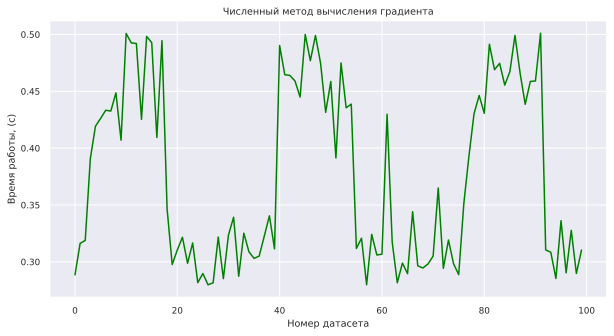

In [40]:
sns.lineplot(data=df_time, x='samples', y='time_utils', color='green')
plt.xlabel('Номер датасета')
plt.ylabel('Время работы, (с)')
plt.title('Численный метод вычисления градиента')
plt.show()

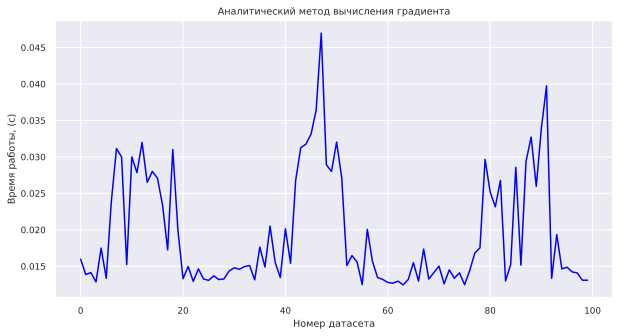

In [41]:
sns.lineplot(data=df_time, x='samples', y='time_oracles', color='blue')
plt.xlabel('Номер датасета')
plt.ylabel('Время работы, (с)')
plt.title('Аналитический метод вычисления градиента')
plt.show()

In [42]:
sns.lineplot(data=df_time, x='samples', y='time_utils', color='green', label='utils')
sns.lineplot(data=df_time, x='samples', y='time_oracles', color='blue', label='oracles')
plt.xlabel('Номер датасета')
plt.ylabel('Время работы')
plt.title('Сравнение способов вычислений градиента')
plt.show()

## Эксперимент 4

Исследовать поведение градиентного спуска для задачи логистической регрессии в зависимости от следующих параметров:

1.   Параметр размера шага ***step_alpha***;
2.   Параметр размера шага ***step_beta***;
3.   Начального приближения.

Изучить:

*   Зависимость значения функции потерь от итерации метода;
*   Зависимость точности (***accuracy***) от итерации метода;
*   Зависимость значения времени работы от итерации метода.
*   Результаты при разных начальных приближениях





### Разделяем выборку на обучающую и валидационную

In [44]:
#  Создаём валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(vector_data_train, target_train, test_size = 0.2, random_state=42)
y_train[y_train == 0] = -1
y_test[y_test == 0] = -1

### Выбор коэффициента регуляризации

In [82]:
alphas = np.logspace(-2, 2, 5)
best_alpha = 1.0
max_accuracy = 0

for alpha in tqdm(alphas):
    clf = GDClassifier('binary_logistic', step_beta=1, l2_coef=alpha)
    clf.fit(X_train, y_train)
    current_accuracy = accuracy_score(y_test, clf.predict(X_test))

    if current_accuracy > max_accuracy:
        max_accuracy = current_accuracy
        best_alpha = alpha

  0%|          | 0/5 [00:00<?, ?it/s]

In [83]:
print('Полученный коэффициент регуляризации:', best_alpha)

Полученный коэффициент регуляризации: 0.01


### Отбор планировщиков коэффициента скорости обучения

In [84]:
step_alphas = np.logspace(-3, 1, 3)
step_betas = np.logspace(-3, 1, 3)

In [85]:
history = np.zeros((3, 3), dtype=object)
i = j = 0

for step_alpha in tqdm(step_alphas):
    j = 0
    for step_beta in tqdm(step_betas):
        clf = GDClassifier('binary_logistic', step_alpha, step_beta, l2_coef=0.01)
        history[i][j] = clf.fit(X_train, y_train, trace=True)
        j += 1
    i += 1

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

### Визуализация полученных результатов

#### Зависимость функции потерь от итерации метода

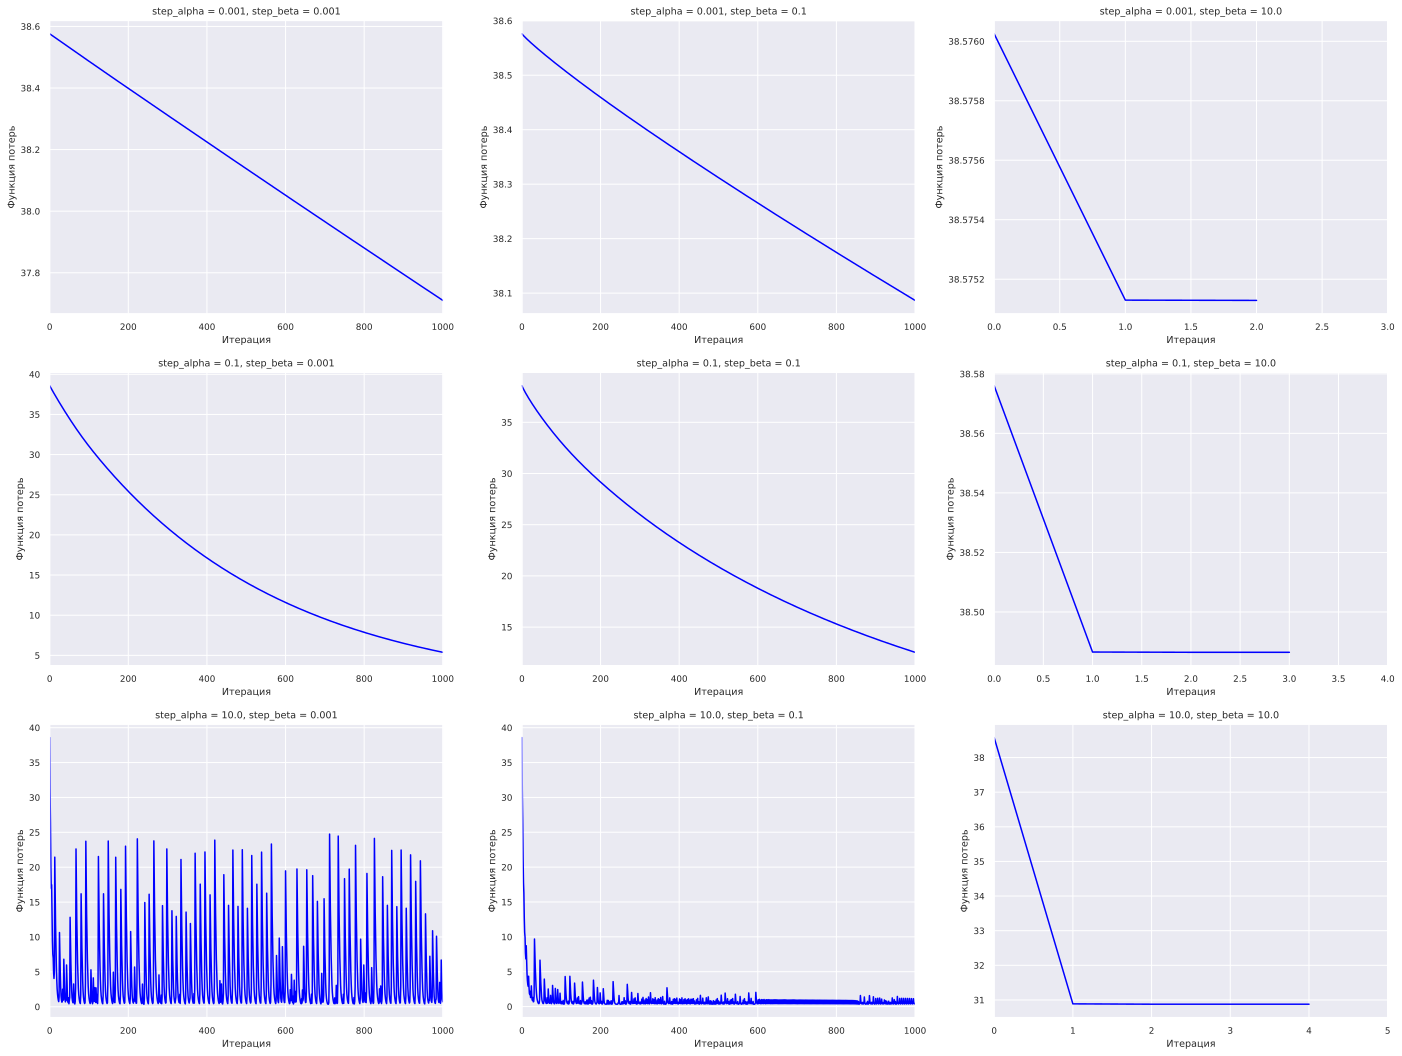

In [97]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(24, 18))

for i in range(3):
    for j in range(3):
        ax[i][j].plot(range(history[i][j]['func'].shape[0]), history[i][j]['func'], color='blue')
        ax[i][j].ticklabel_format(style='plain', useMathText=False, useOffset=False)
        ax[i][j].set(title=f'step_alpha = {step_alphas[i]}, step_beta = {step_betas[j]}',
                     xlabel='Итерация',
                     ylabel='Функция потерь',
                     xlim=[0, history[i][j]['func'].shape[0]])

fig.savefig('history_gd_w_1_func.svg')
fig.show()

#### Зависимость точности от итерации метода

In [98]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(24, 18))

for i in range(3):
    for j in range(3):
        ax[i][j].plot(range(history[i][j]['acc'].shape[0]), history[i][j]['acc'], color='blue')
        ax[i][j].ticklabel_format(style='plain', useMathText=False, useOffset=False)
        ax[i][j].set(title=f'step_alpha = {step_alphas[i]}, step_beta = {step_betas[j]}',
                     xlabel='Итерация',
                     ylabel='Точность',
                     xlim=[0, history[i][j]['acc'].shape[0]])

fig.savefig('history_gd_w_1_acc.svg')
fig.show()

#### Зависимость времени работы от итерации метода

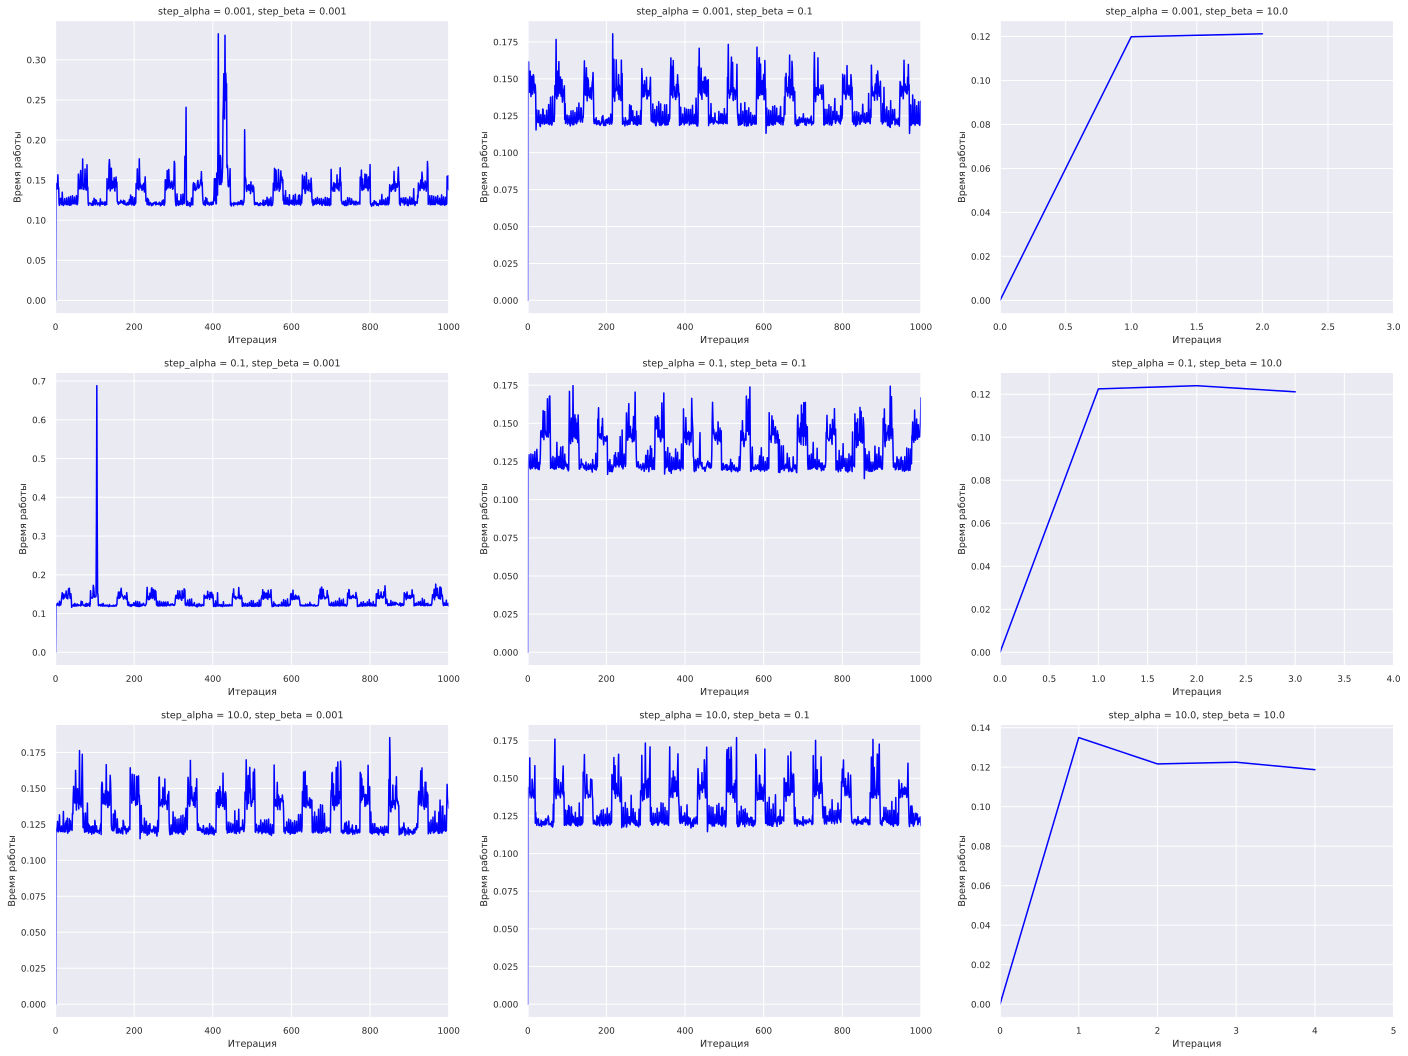

In [99]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(24, 18))

for i in range(3):
    for j in range(3):
        ax[i][j].plot(range(history[i][j]['time'].shape[0]), history[i][j]['time'], color='blue')
        ax[i][j].ticklabel_format(style='plain', useMathText=False, useOffset=False)
        ax[i][j].set(title=f'step_alpha = {step_alphas[i]}, step_beta = {step_betas[j]}',
                     xlabel='Итерация',
                     ylabel='Время работы',
                     xlim=[0, history[i][j]['time'].shape[0]])

fig.savefig('history_gd_w_1_time.svg')
fig.show()

#### Оценка полученных результатов

In [101]:
# Крайние оценки

max_acc = [-1, -1, -1]
min_loss = [100, -1, -1]
min_time = [100, -1, -1]

for i in range(3):
    for j in range(3):
        if history[i][j]['acc'].max() > max_acc[0]:
            max_acc[0] = history[i][j]['acc'].max()
            max_acc[1] = i
            max_acc[2] = j
        if history[i][j]['func'].min() < min_loss[0]:
            min_loss[0] = history[i][j]['func'].min()
            min_loss[1] = i
            min_loss[2] = j
        if history[i][j]['time'].sum() < min_time[0]:
            min_time[0] = history[i][j]['time'].sum()
            min_time[1] = i
            min_time[2] = j
print(f'Максимальная точность: {max_acc[0]} для step_alpha = {step_alphas[max_acc[1]]}, step_beta = {step_betas[max_acc[2]]}')
print(f'Минимальный лосс: {min_loss[0]} для step_alpha = {step_alphas[min_loss[1]]}, step_beta = {step_betas[min_loss[2]]}')
print(f'Минимальное полное время работы: {min_time[0]} для step_alpha = {step_alphas[min_time[1]]}, step_beta = {step_betas[min_time[2]]}')

Максимальная точность: 0.930085542395187 для step_alpha = 10.0, step_beta = 0.001
Минимальный лосс: 0.3425970010494023 для step_alpha = 10.0, step_beta = 0.1
Минимальное полное время работы: 0.24102425575256348 для step_alpha = 0.001, step_beta = 10.0


Анализ графиков показывает, что значения $step\_alpha = 0.1, \: step\_beta = 0.001$ являются самыми оптимальными.

In [90]:
print(f'Оптимальный лосс: {history[1][0]["func"].min()}')
print(f'Оптимальная точность: {history[1][0]["acc"].max()}')
print(f'Оптимальное время работы (суммируем по всем итерациям): {history[1][0]["time"].sum()}')

Оптимальный лосс: 5.384332469869965
Оптимальная точность: 0.9227298364354202
Оптимальное время работы (суммируем по всем итерациям): 131.64455938339233


### Изучение различных приближений

Будем рассматривать начальное приближение как случайный выбор весов из равномерного распределения в дополнение к подходу со скалярными произведениями.

In [91]:
clf = GDClassifier('binary_logistic', step_alpha=0.1, step_beta=0.001, l2_coef=0.01, uniform_w_0=True)
history_w_0 = clf.fit(X_train, y_train, trace=True)

#### Визуализация

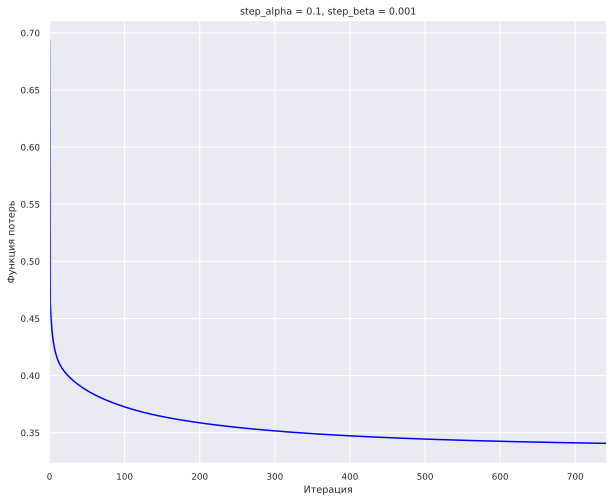

In [104]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(range(history_w_0['func'].shape[0]), history_w_0['func'], color='blue')
ax.ticklabel_format(style='plain', useMathText=False, useOffset=False)
ax.set(title=f'step_alpha = {0.1}, step_beta = {0.001}',
       xlabel='Итерация',
       ylabel='Функция потерь',
       xlim=[0, history_w_0['func'].shape[0]])

fig.savefig('history_gd_w_0_func.svg')
fig.show()

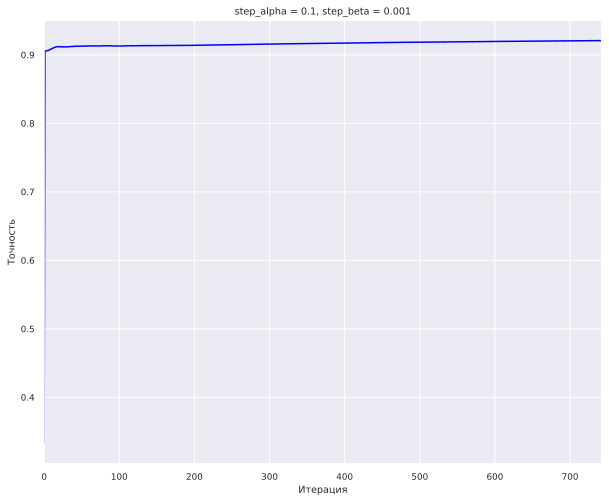

In [105]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(range(history_w_0['acc'].shape[0]), history_w_0['acc'], color='blue')
ax.ticklabel_format(style='plain', useMathText=False, useOffset=False)
ax.set(title=f'step_alpha = {0.1}, step_beta = {0.001}',
       xlabel='Итерация',
       ylabel='Точность',
       xlim=[0, history_w_0['acc'].shape[0]])

fig.savefig('history_gd_w_0_acc.svg')
fig.show()

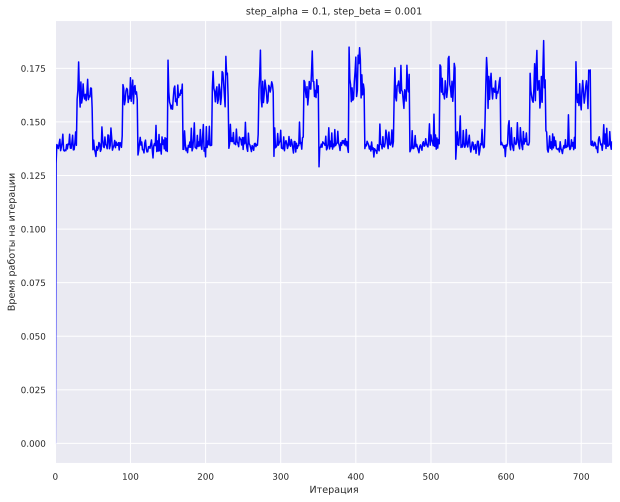

In [106]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(range(history_w_0['time'].shape[0]), history_w_0['time'], color='blue')
ax.ticklabel_format(style='plain', useMathText=False, useOffset=False)
ax.set(title=f'step_alpha = {0.1}, step_beta = {0.001}',
       xlabel='Итерация',
       ylabel='Время работы на итерации',
       xlim=[0, history_w_0['time'].shape[0]])

fig.savefig('history_gd_w_0_time.svg')
fig.show()

In [95]:
print(f'Лучшая точность: {history_w_0["acc"].max()}')
print(f'Минимальное значение функции потерь: {history_w_0["func"].min()}')
print(f'Время работы: {history_w_0["time"].sum()}')

Лучшая точность: 0.9207557811618725
Минимальное значение функции потерь: 0.3406903388522946
Время работы: 110.1018271446228


Для данных весов получаем незначительно меньшую точность, гораздо меньшие значения функции потерь и времени работы. Однако такой маленький лосс может вести к сильному переобучению, поэтому в дальнейшем будет оставлен вариант с инициализацией весов через скалярное произведение

### Краткий итог эксперимента

$GDClassifier$ работает лучше со следующими параметрами:
1. $step\_alpha = 0.1$
2. $step\_beta = 0.001$
3. Коэффициент регуляризации $l_2\_coef = 0.01$
4. Начальное приближение весов через скалярные произведения

Полученные значения:
1. $Accuracy = 0.9227$
2. $Loss = 5.3843$
3. $Time_{total} = 131.645$

## Эксперимент 5

Исследовать поведение стохастического градиентного спуска для задачи логистической регрессии в зависимости от следующих параметров:

1.   Параметр размера шага ***step_alpha***;
2.   Параметр размера шага ***step_beta***;
3.   Параметр подвыборки ***batch_size***;
4.   Начального приближения.

Изучить:

*   Зависимость значения функции потерь от эпохи метода;
*   Зависимость точности (***accuracy***) от эпохи метода;
*   Зависимость значения времени работы от эпохи метода.
*   Результаты при разных начальных приближениях
*   Результаты при разных параметрах подвыборки

### Выбор коэффициента регуляризации

In [45]:
alphas = np.logspace(-3, 1, 5)
best_alpha_sgd = 1.0
max_accuracy_sgd = 0

for alpha in tqdm(alphas):
    clf = SGDClassifier('binary_logistic', batch_size=1, step_alpha=0.1, step_beta=0.001, l2_coef=alpha)
    clf.fit(X_train, y_train)
    current_accuracy = accuracy_score(y_test, clf.predict(X_test))

    if current_accuracy > max_accuracy_sgd:
        max_accuracy_sgd = current_accuracy
        best_alpha_sgd = alpha

  0%|          | 0/5 [00:00<?, ?it/s]

In [46]:
print("Полученный коэффициент регуляризации:", best_alpha_sgd)
print("Качество на валидации при полученном коэффициенте:", max_accuracy_sgd)

Полученный коэффициент регуляризации: 1.0
Качество на валидации при полученном коэффициенте: 0.9011436628544571


### Отбор планировщиков коэффициента скорости обучения

In [47]:
step_alphas = np.logspace(-2, 0, 3)
step_betas = np.logspace(-3, 0, 3)

In [48]:
history_sgd = np.zeros((3, 3), dtype=object)
i = j = 0

for step_alpha in tqdm(step_alphas):
    j = 0
    for step_beta in tqdm(step_betas):
        clf = SGDClassifier('binary_logistic', batch_size=1, step_alpha=step_alpha, step_beta=step_beta, l2_coef=1)
        history_sgd[i][j] = clf.fit(X_train, y_train, log_freq=0.00001, trace=True)
        j += 1
    i += 1

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

### Зависимость функции потерь от эпохи метода

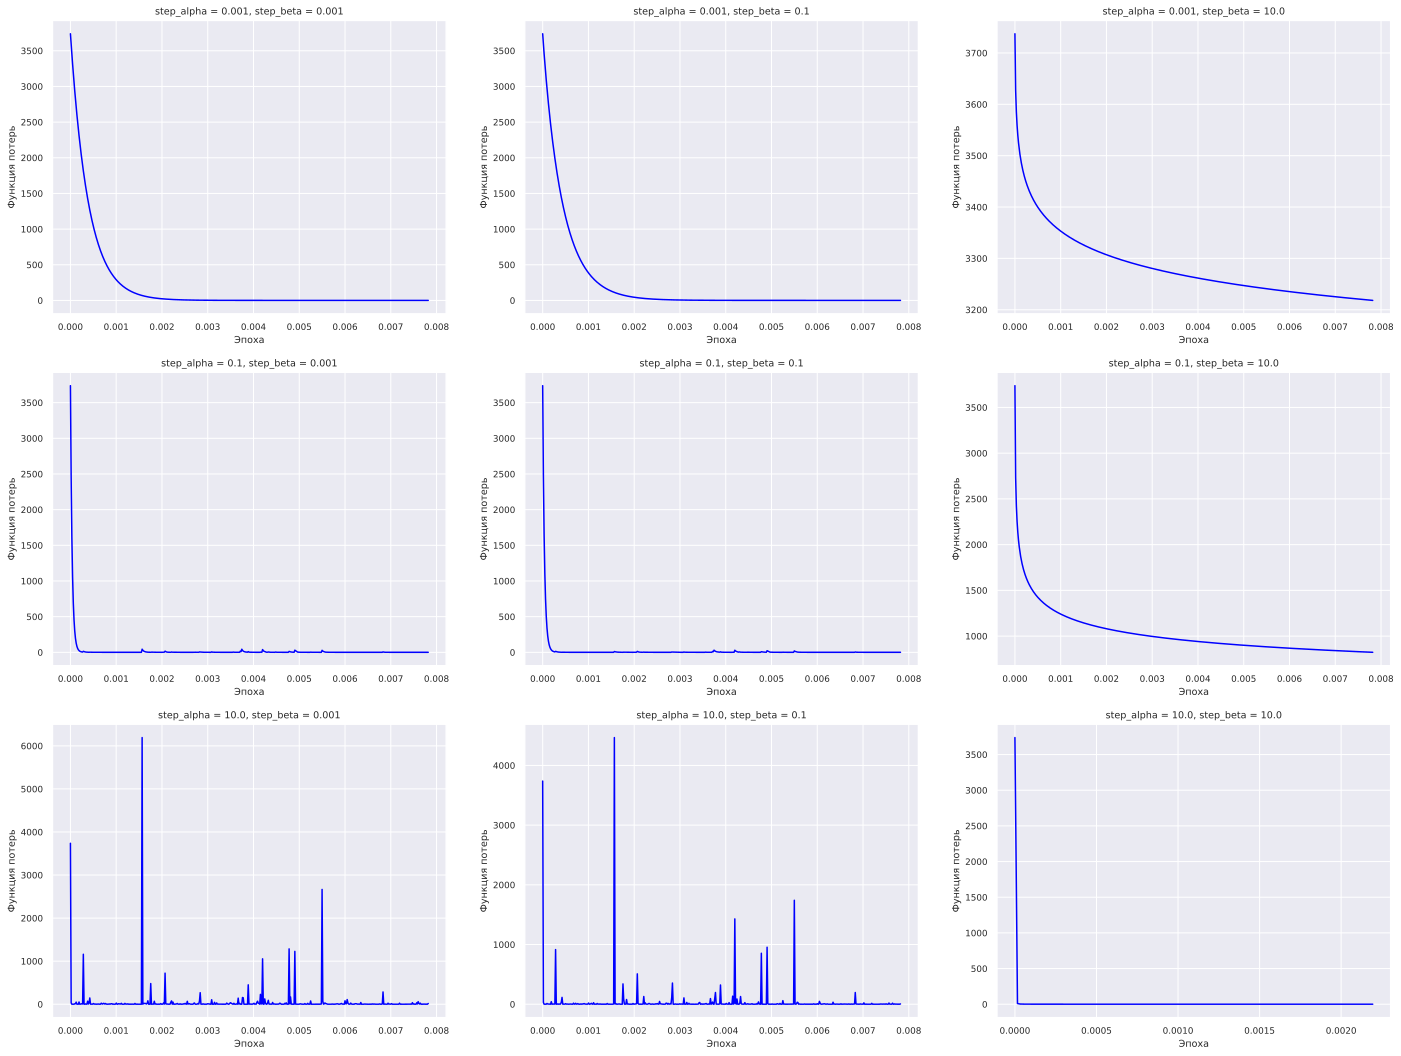

In [107]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(24, 18))

for i in range(3):
    for j in range(3):
        ax[i][j].plot(history_sgd[i][j]['epoch_num'], history_sgd[i][j]['func'], color='blue')
        ax[i][j].ticklabel_format(style='plain', useMathText=False, useOffset=False)
        ax[i][j].set(title=f'step_alpha = {step_alphas[i]}, step_beta = {step_betas[j]}',
                     xlabel='Эпоха',
                     ylabel='Функция потерь')

fig.savefig('history_sgd_w_1_func.svg')
fig.show()

### Зависимость точности от эпохи метода

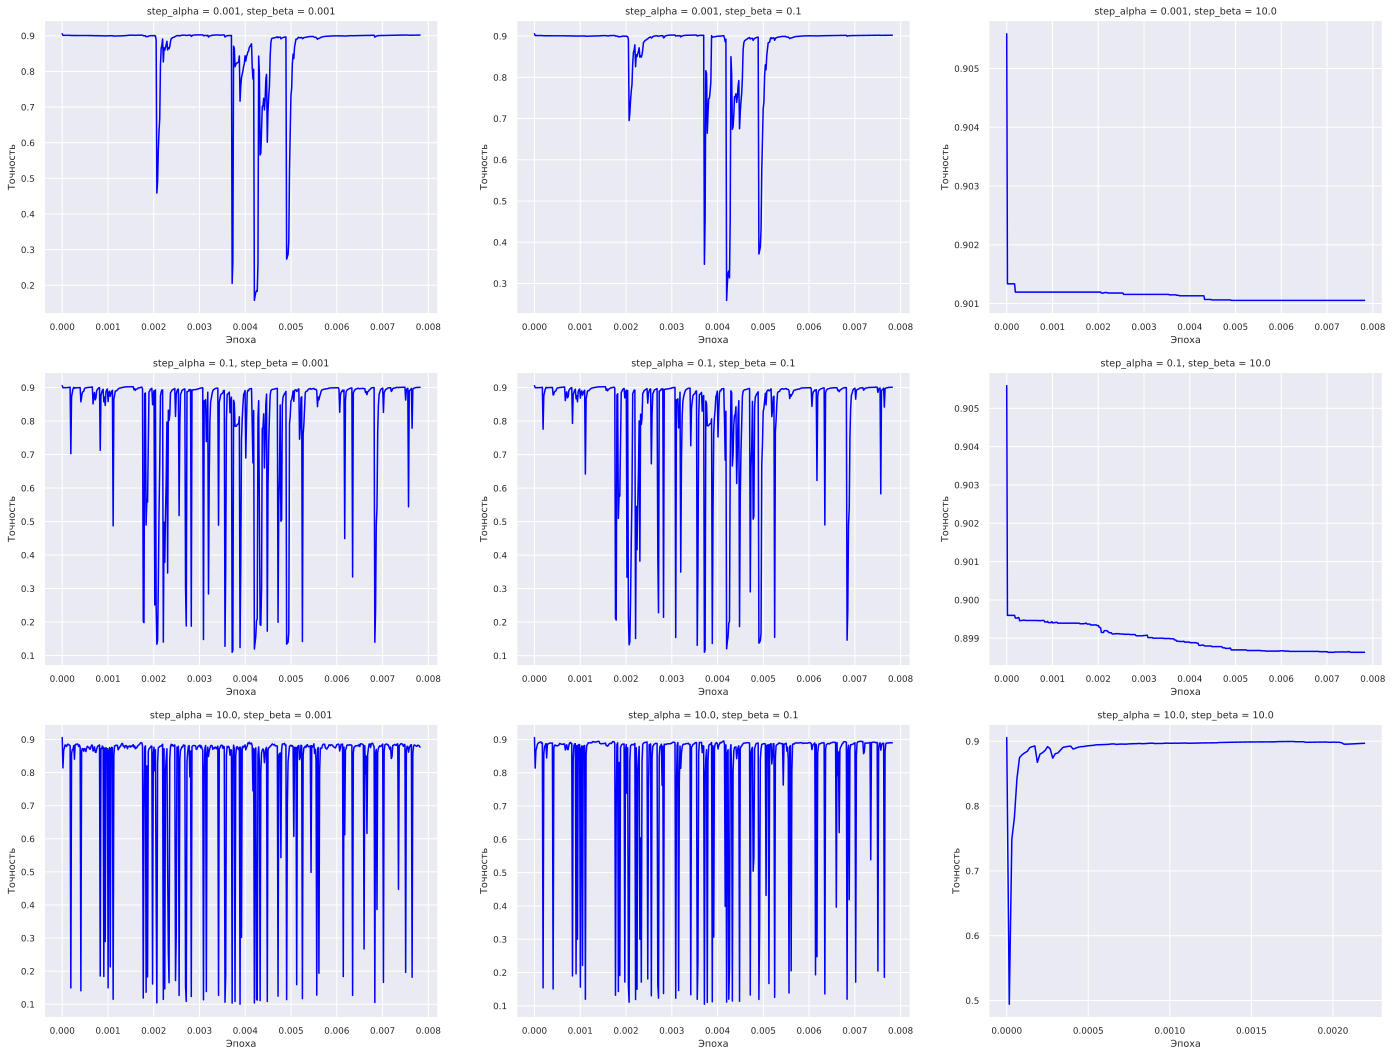

In [108]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(24, 18))

for i in range(3):
    for j in range(3):
        ax[i][j].plot(history_sgd[i][j]['epoch_num'], history_sgd[i][j]['acc'], color='blue')
        ax[i][j].ticklabel_format(style='plain', useMathText=False, useOffset=False)
        ax[i][j].set(title=f'step_alpha = {step_alphas[i]}, step_beta = {step_betas[j]}',
                     xlabel='Эпоха',
                     ylabel='Точность')

fig.savefig('history_sgd_w_1_acc.svg')
fig.show()

### Зависимость времени работы от эпохи метода

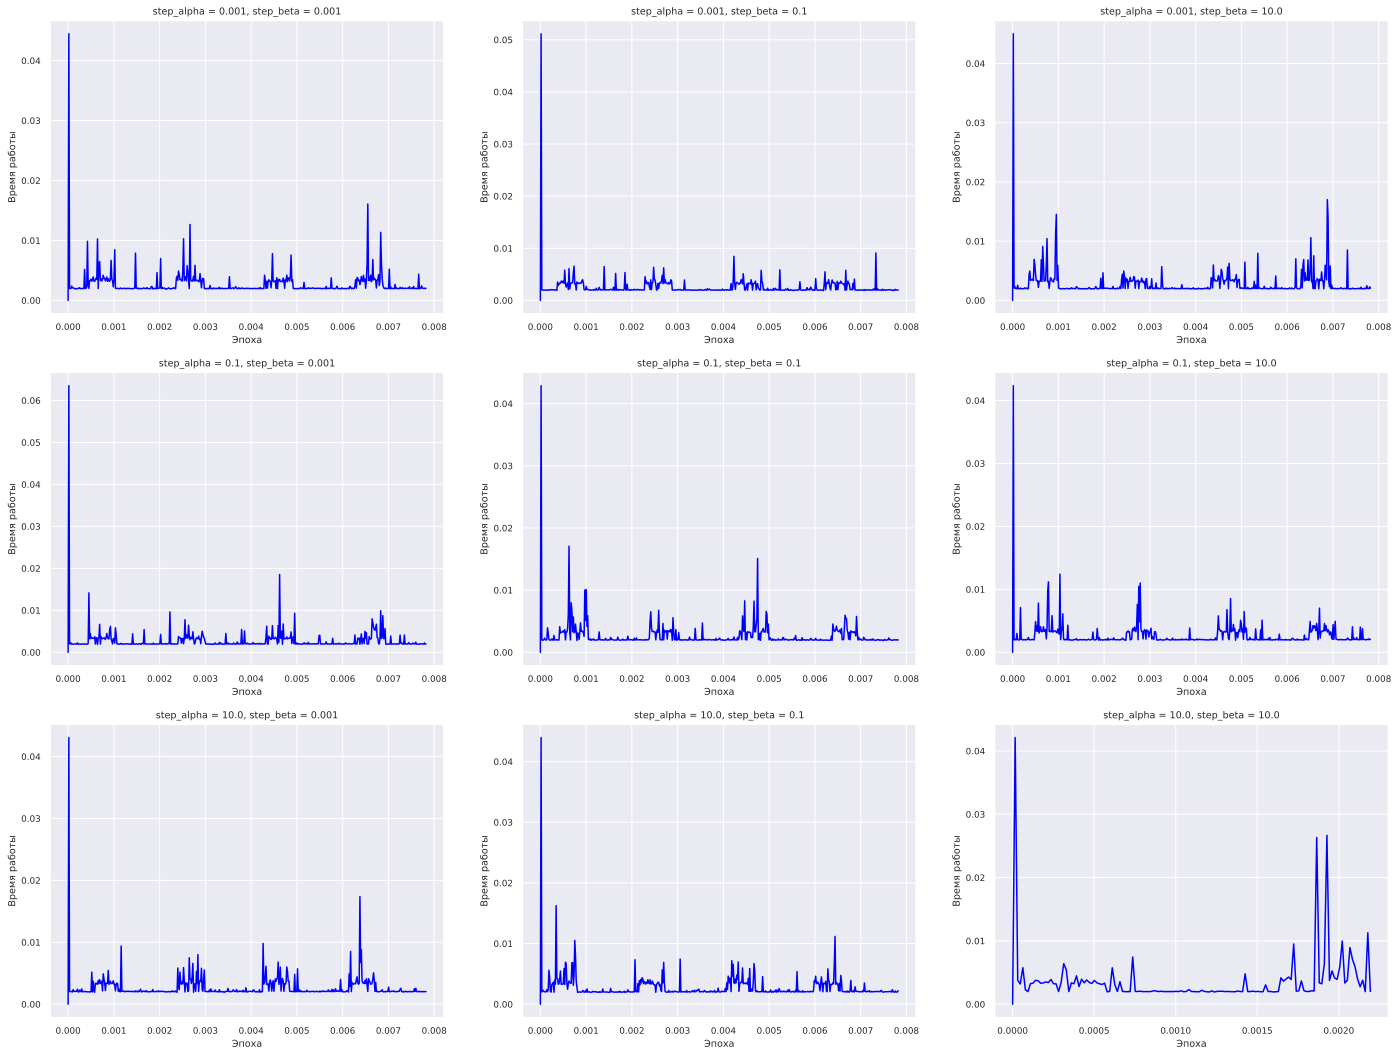

In [109]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(24, 18))

for i in range(3):
    for j in range(3):
        ax[i][j].plot(history_sgd[i][j]['epoch_num'], history_sgd[i][j]['time'], color='blue')
        ax[i][j].ticklabel_format(style='plain', useMathText=False, useOffset=False)
        ax[i][j].set(title=f'step_alpha = {step_alphas[i]}, step_beta = {step_betas[j]}',
                     xlabel='Эпоха',
                     ylabel='Время работы')

fig.savefig('history_sgd_w_1_time.svg')
fig.show()

### Оценка полученных результатов

In [52]:
max_acc_sgd = [-1, -1, -1]
min_loss_sgd = [100, -1, -1]
min_time_sgd = [100, -1, -1]

for i in range(3):
    for j in range(3):
        if history_sgd[i][j]['acc'].max() > max_acc_sgd[0]:
            max_acc_sgd[0] = history_sgd[i][j]['acc'].max()
            max_acc_sgd[1] = i
            max_acc_sgd[2] = j
        if history_sgd[i][j]['func'].min() < min_loss_sgd[0]:
            min_loss_sgd[0] = history_sgd[i][j]['func'].min()
            min_loss_sgd[1] = i
            min_loss_sgd[2] = j
        if history_sgd[i][j]['time'].min() < min_time_sgd[0]:
            min_time_sgd[0] = history_sgd[i][j]['time'].sum()
            min_time_sgd[1] = i
            min_time_sgd[2] = j
print(f'Максимальная точность: {max_acc_sgd[0]} для step_alpha = {step_alphas[max_acc_sgd[1]]}, step_beta = {step_betas[max_acc_sgd[2]]}')
print(f'Минимальный лосс: {min_loss_sgd[0]} для step_alpha = {step_alphas[min_loss_sgd[1]]}, step_beta = {step_betas[min_loss_sgd[2]]}')
print(f'Суммарное время работы: {min_time_sgd[0]} для step_alpha = {step_alphas[min_time_sgd[1]]}, step_beta = {step_betas[min_time_sgd[2]]}')

Максимальная точность: 0.905590023187316 для step_alpha = 0.01, step_beta = 0.001
Минимальный лосс: 0.5506232593657836 для step_alpha = 1.0, step_beta = 1.0
Суммарное время работы: 0.5186874866485596 для step_alpha = 1.0, step_beta = 1.0


Анализ графиков показывает, что в случае $SGD$ лучшими параметрами являются $step\_alpha = 1.0, \: step\_beta = 1.0$ при коэффициенте регуляризации $1.0$

### Изучение различных приближений

Будем рассматривать изначальное приближение весов, сэмплированное из равномерного распределения. На данных весах также будем подбирать $batch\_size$

#### Случайный выбор весов

In [53]:
batches = 2 ** np.arange(11)

history_sgd_w_0 = np.zeros((11), dtype=object)

i = 0
for batch_size in tqdm(batches):
    clf = SGDClassifier('binary_logistic', batch_size=batch_size, step_alpha=1.0, step_beta=1.0, l2_coef=1.0, uniform_w_0=True)
    history_sgd_w_0[i] = clf.fit(X_train, y_train, log_freq=0.0001, trace=True)
    i += 1

  0%|          | 0/11 [00:00<?, ?it/s]

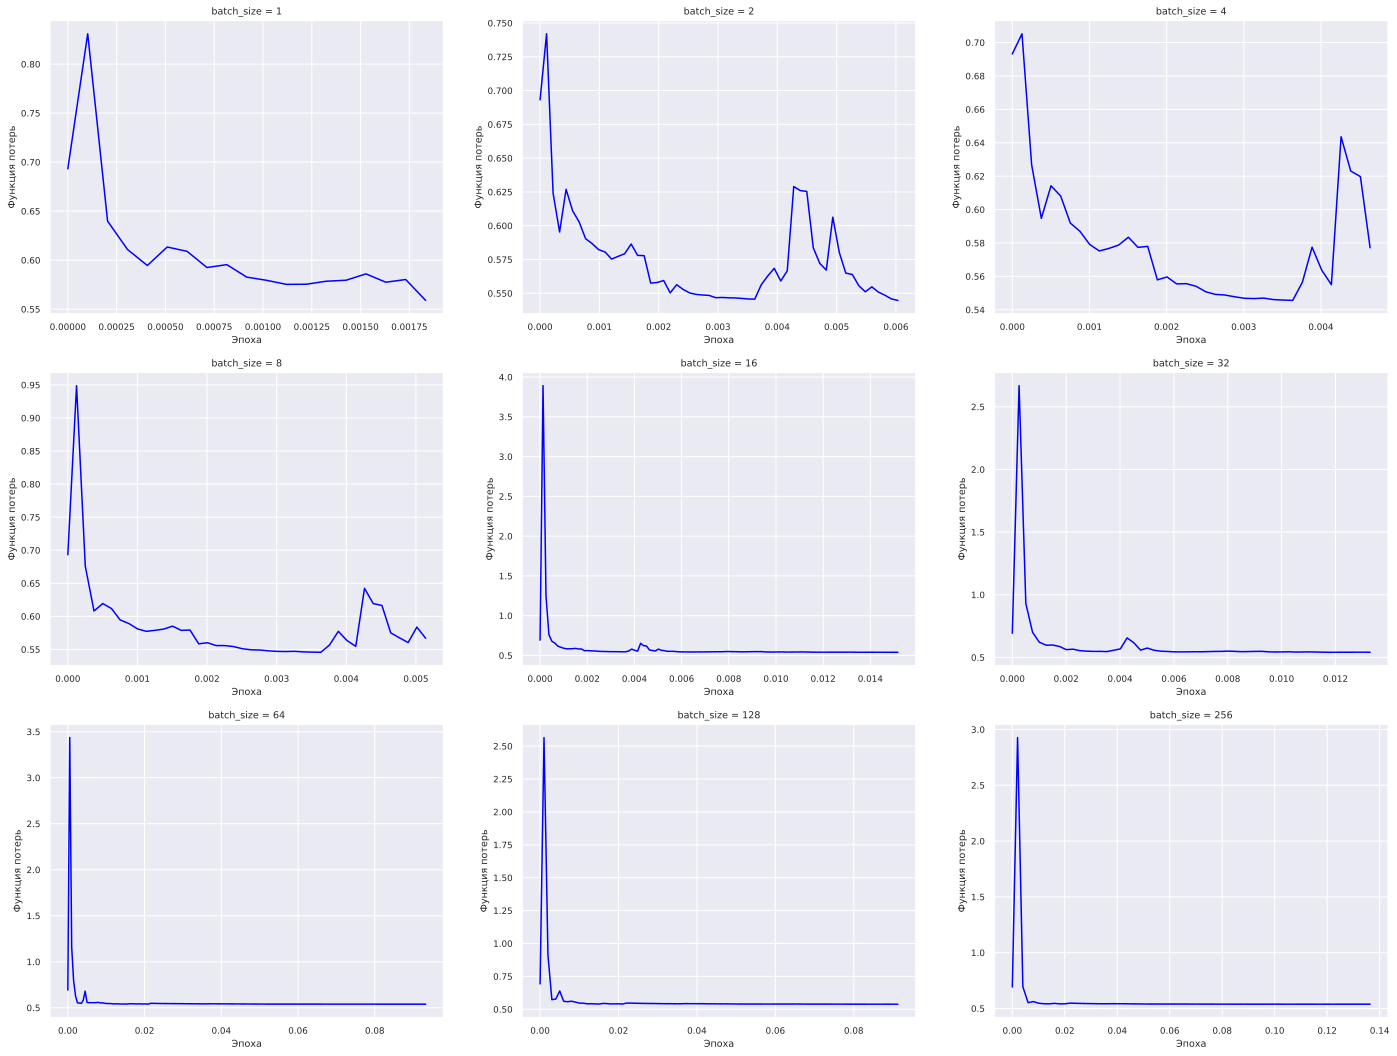

In [111]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(24, 18))

for i in range(3):
    for j in range(3):
        ax[i][j].plot(history_sgd_w_0[3 * i + j]['epoch_num'], history_sgd_w_0[3 * i + j]['func'], color='blue')
        ax[i][j].ticklabel_format(style='plain', useMathText=False, useOffset=False)
        ax[i][j].set(title=f'batch_size = {batches[3 * i + j]}',
                     xlabel='Эпоха',
                     ylabel='Функция потерь')

fig.savefig('history_sgd_w_0_func.svg')
fig.show()

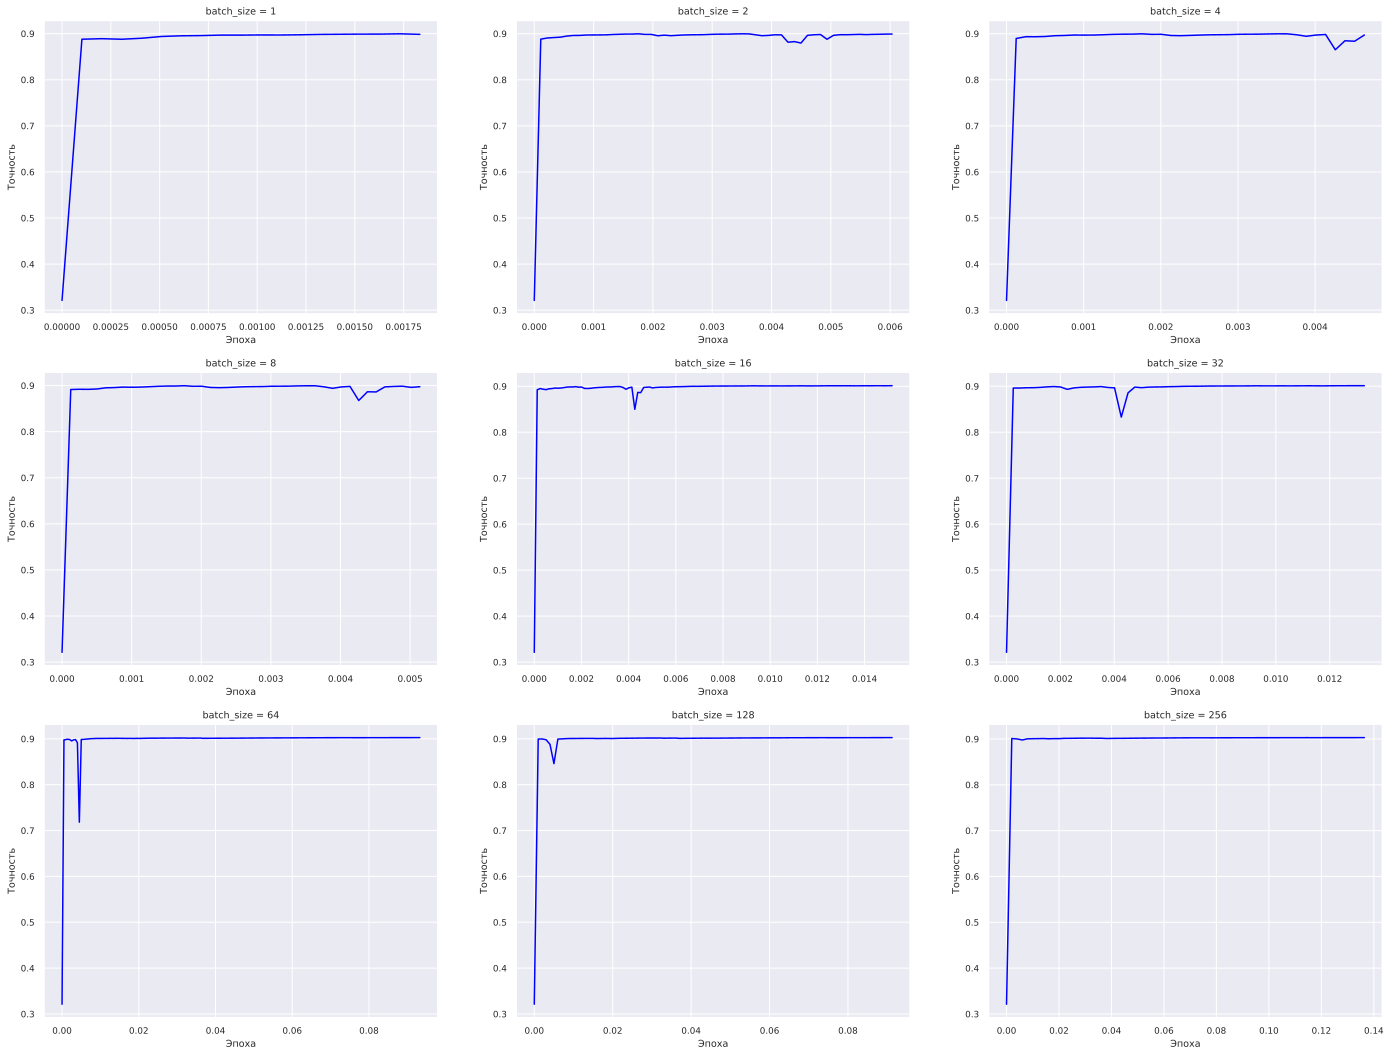

In [112]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(24, 18))

for i in range(3):
    for j in range(3):
        ax[i][j].plot(history_sgd_w_0[3 * i + j]['epoch_num'], history_sgd_w_0[3 * i + j]['acc'], color='blue')
        ax[i][j].ticklabel_format(style='plain', useMathText=False, useOffset=False)
        ax[i][j].set(title=f'batch_size = {batches[3 * i + j]}',
                     xlabel='Эпоха',
                     ylabel='Точность')

fig.savefig('history_sgd_w_0_acc.svg')
fig.show()

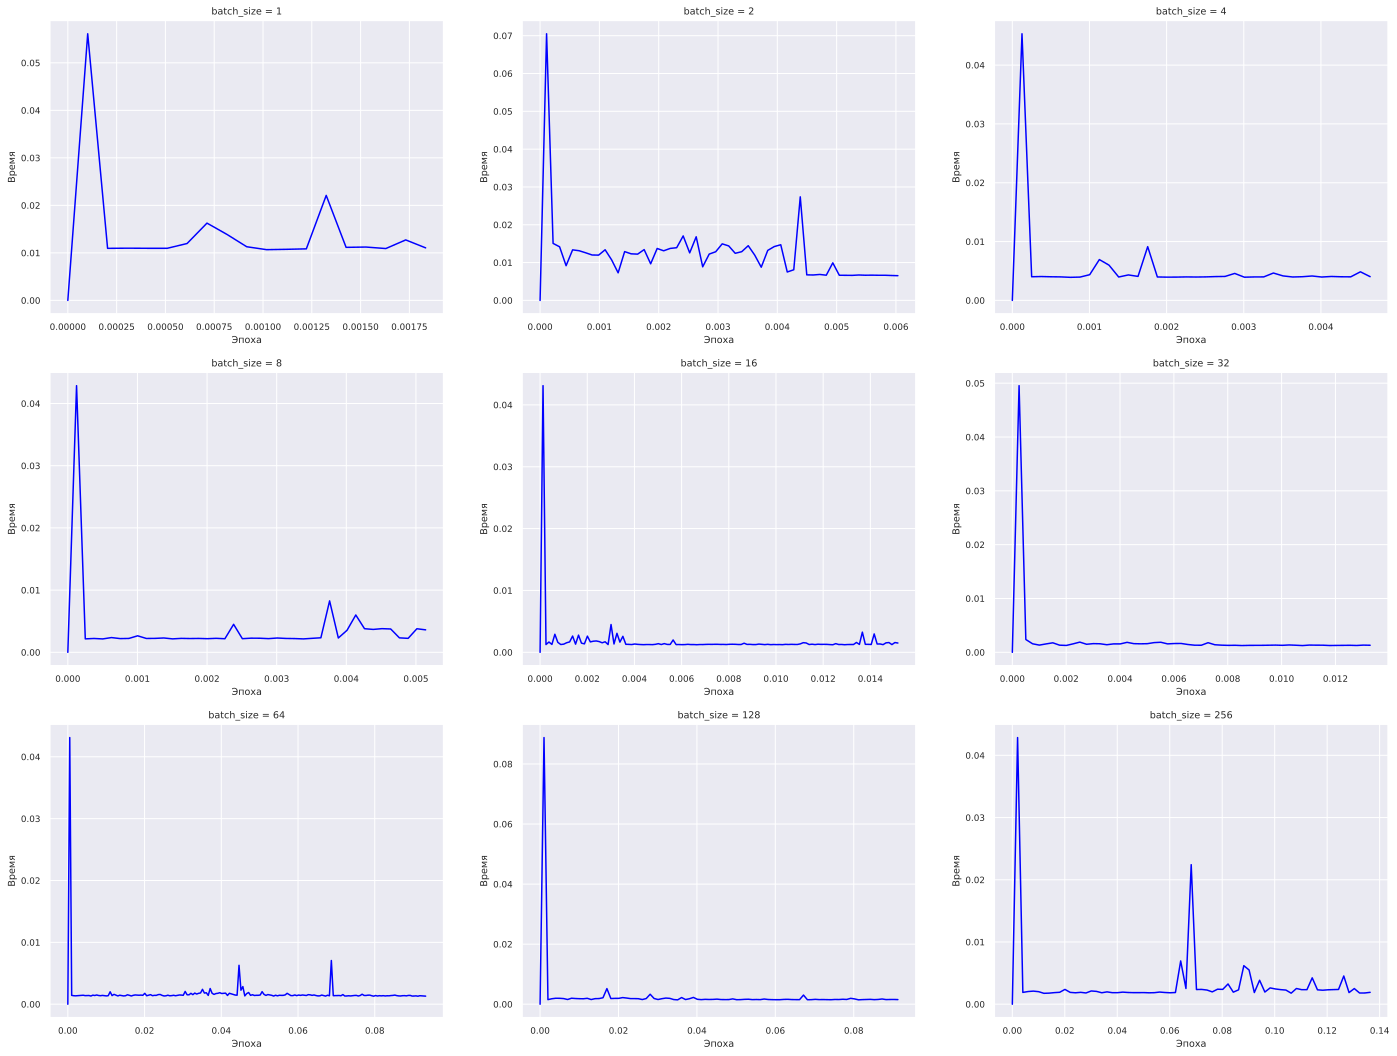

In [113]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(24, 18))

for i in range(3):
    for j in range(3):
        ax[i][j].plot(history_sgd_w_0[3 * i + j]['epoch_num'], history_sgd_w_0[3 * i + j]['time'], color='blue')
        ax[i][j].ticklabel_format(style='plain', useMathText=False, useOffset=False)
        ax[i][j].set(title=f'batch_size = {batches[3 * i + j]}',
                     xlabel='Эпоха',
                     ylabel='Время')

fig.savefig('history_sgd_w_0_time.svg')
fig.show()

#### Веса через скалярное произведение

In [62]:
history_sgd_w_1 = np.zeros((11), dtype=object)

i = 0
for batch_size in tqdm(batches):
    clf = SGDClassifier('binary_logistic', batch_size=batch_size, step_alpha=1.0, step_beta=1.0, l2_coef=1.0)
    history_sgd_w_1[i] = clf.fit(X_train, y_train, log_freq=0.0001, trace=True)
    i += 1

  0%|          | 0/11 [00:00<?, ?it/s]

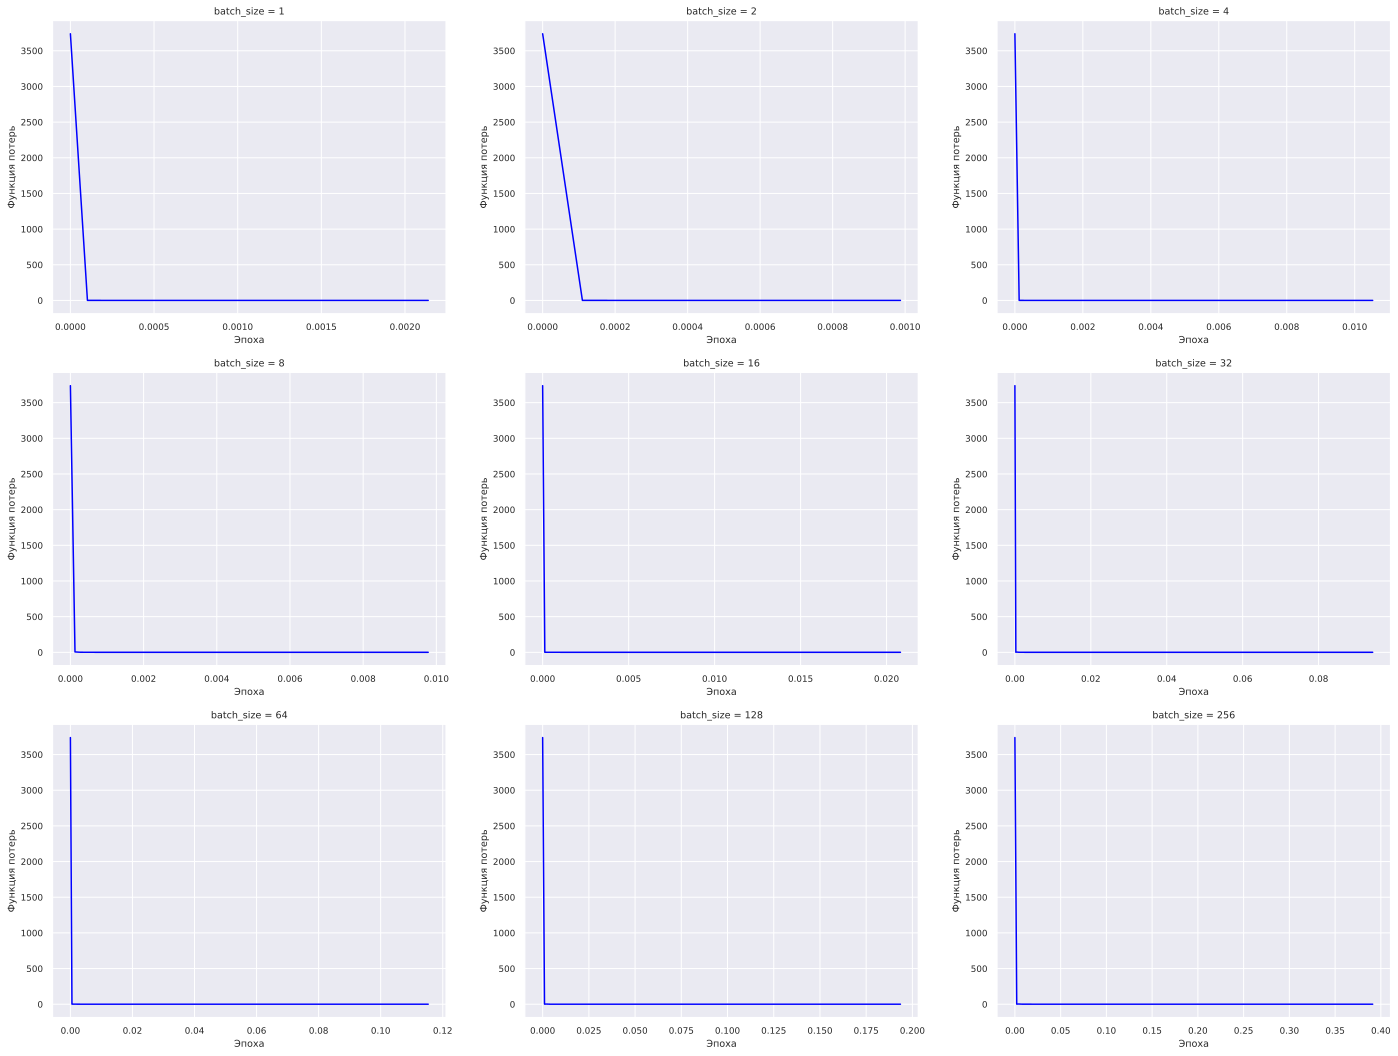

In [115]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(24, 18))

for i in range(3):
    for j in range(3):
        ax[i][j].plot(history_sgd_w_1[3 * i + j]['epoch_num'], history_sgd_w_1[3 * i + j]['func'], color='blue')
        ax[i][j].ticklabel_format(style='plain', useMathText=False, useOffset=False)
        ax[i][j].set(title=f'batch_size = {batches[3 * i + j]}',
                     xlabel='Эпоха',
                     ylabel='Функция потерь')

fig.savefig('history_sgd_batch_w_1_func.svg')
fig.show()

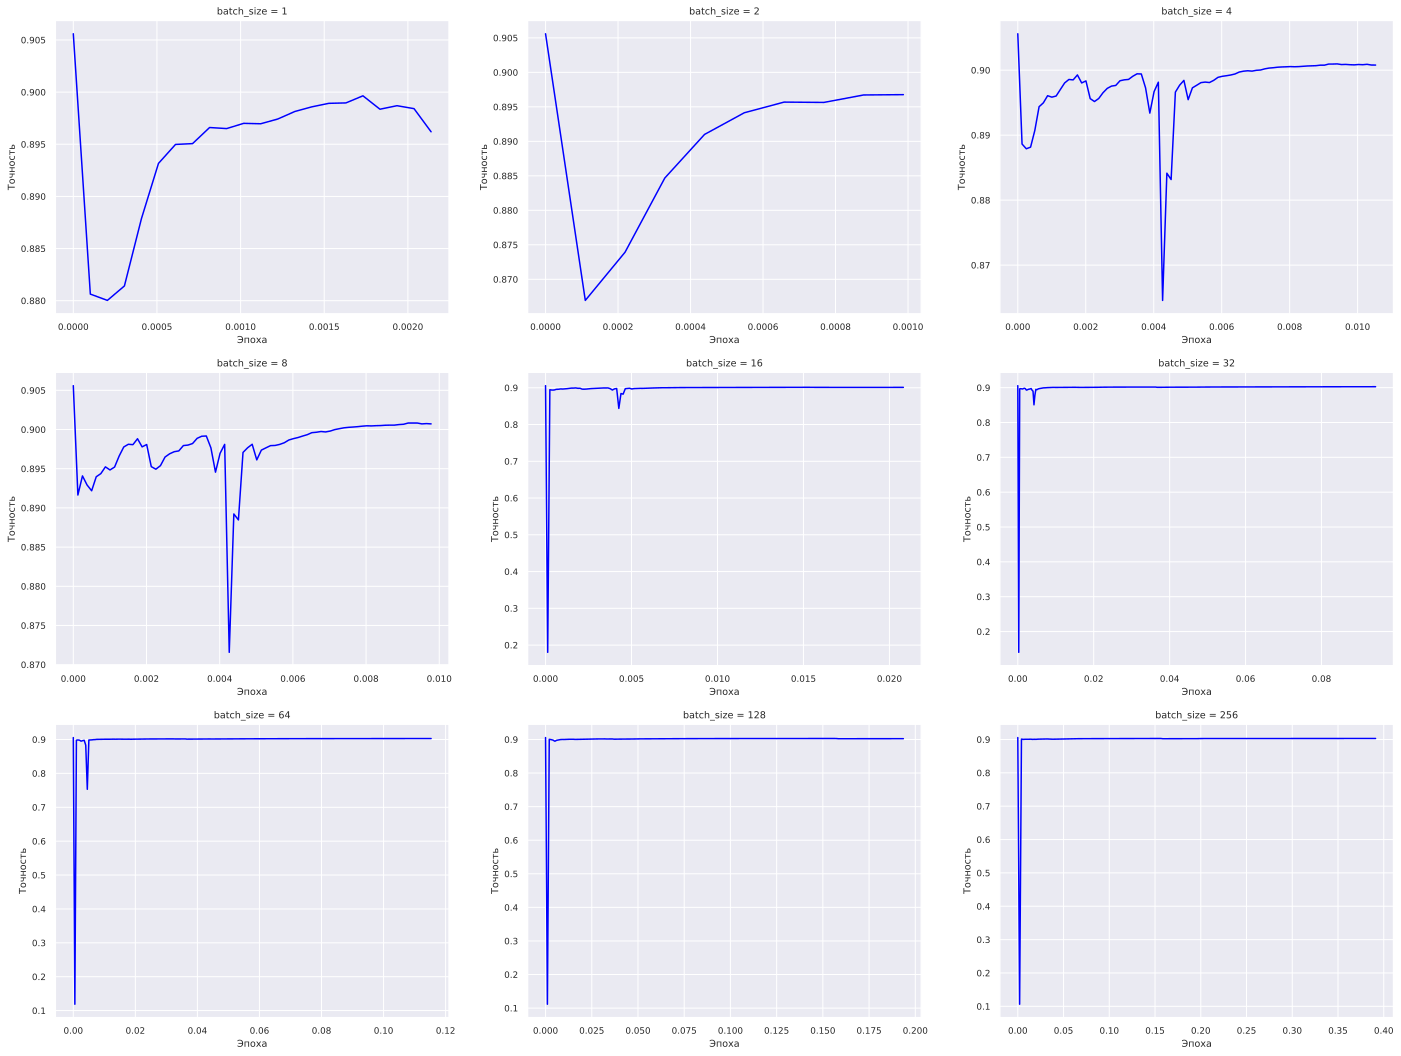

In [116]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(24, 18))

for i in range(3):
    for j in range(3):
        ax[i][j].plot(history_sgd_w_1[3 * i + j]['epoch_num'], history_sgd_w_1[3 * i + j]['acc'], color='blue')
        ax[i][j].ticklabel_format(style='plain', useMathText=False, useOffset=False)
        ax[i][j].set(title=f'batch_size = {batches[3 * i + j]}',
                     xlabel='Эпоха',
                     ylabel='Точность')

fig.savefig('history_sgd_batch_w_1_acc.svg')
fig.show()

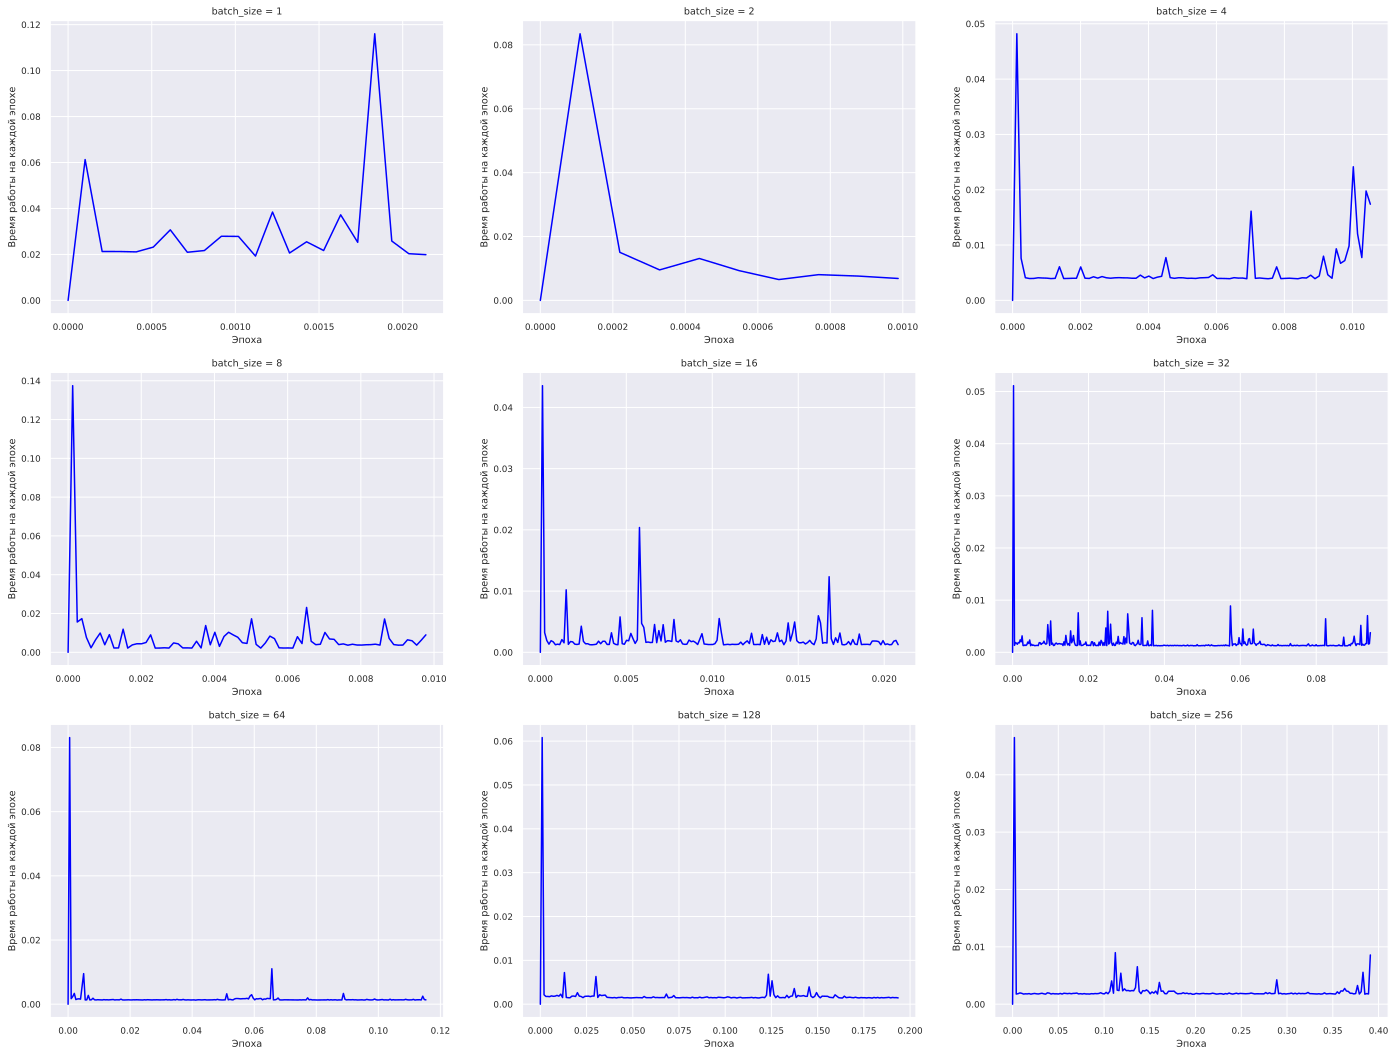

In [117]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(24, 18))

for i in range(3):
    for j in range(3):
        ax[i][j].plot(history_sgd_w_1[3 * i + j]['epoch_num'], history_sgd_w_1[3 * i + j]['time'], color='blue')
        ax[i][j].ticklabel_format(style='plain', useMathText=False, useOffset=False)
        ax[i][j].set(title=f'batch_size = {batches[3 * i + j]}',
                     xlabel='Эпоха',
                     ylabel='Время работы на каждой эпохе')

fig.savefig('history_sgd_batch_w_1_time.svg')
fig.show()

#### Оценка результатов подбора $batch\_size$

In [81]:
print('Точность с инициализацией через скалярные произведения (batch_size = 256)', history_sgd_w_1[8]['acc'][-1])
print('Точность со случайной инициализацией из равномерного распределения (batch_size = 256)', history_sgd_w_0[8]['acc'][-1])
print('Разница в точности:', abs(history_sgd_w_1[8]['acc'][-1] - history_sgd_w_0[8]['acc'][-1]))
print('Значение функции потерь:', history_sgd_w_1[8]['func'][-1])
print('Суммарное вребя работы:', history_sgd_w_1[8]['time'].sum())

Точность с инициализацией через скалярные произведения (batch_size = 256) 0.9030206179106348
Точность со случайной инициализацией из равномерного распределения (batch_size = 256) 0.9030049508052892
Разница в точности: 1.5667105345618104e-05
Значение функции потерь: 0.5380998226992404
Суммарное вребя работы: 0.4533958435058594


### Краткий итог эксперимента

$SGDClassifier$ работает лучше со следующими параметрами:
1. $step\_alpha = 1.0$
2. $step\_beta = 1.0$
3. $batch\_size = 256$
4. Коэффициент регуляризации $l_2\_coef = 1.0$
5. Начальное приближение весов через скалярные произведения

Полученные значения:
1. $Accuracy = 0.90302$
2. $Loss =  0.538$
3. $Time_{total} = 0.4534$

## Эксперимент 6

Сравнить поведение $GDClassifier$ и $SGDClassifier$ между собой и сделать выводы

### Сравнение по лучшим результатам

$GDClassifier \:\: versus \:\: SGDClassifier$ :
1. $step\_alpha = 0.1 \:$ vs $\: step\_alpha = 1.0$
2. $step\_beta = 0.001 \:$ vs $\: step\_beta = 1.0$
3. $l_2\_coef = 0.01 \:$ vs $\: l_2\_coef = 1.0$
4. Начальное приближение весов через скалярные произведения (Одинаково)
5. $batch\_size = 256 \:$ - только для $SGDClassifier$

Полученные значения:
1. $Accuracy = 0.9227 \:$ vs $\: Accuracy = 0.90302$
2. $Loss = 5.3843 \:$ vs $\: Loss =  0.538$
3. $Time_{total} = 131.645 \:$ vs $\: Time_{total} = 0.4534$

In [120]:
clf_gd = GDClassifier(loss_function='binary_logistic', step_alpha=0.1, step_beta=0.001, l2_coef=0.01)
clf_sgd = SGDClassifier(loss_function='binary_logistic', batch_size=256, step_alpha=1.0, step_beta=1.0, l2_coef=1.0)

start_time = time()
fitted_gd = clf_gd.fit(X_train, y_train)
gd_time = time() - start_time

start_time = time()
fitted_sgd = clf_sgd.fit(X_train, y_train)
sgd_time = time() - start_time

In [121]:
print('Время обучения GDClassifier:', gd_time)
print('Время обучения SGDClassifier:', sgd_time, end='\n\n')

print('GD Accuracy (TEST):', accuracy_score(y_test, clf_gd.predict(X_test)))
print('SGD Accuracy (TEST):', accuracy_score(y_test, clf_sgd.predict(X_test)))
print('GD Accuracy (TRAIN):', accuracy_score(y_train, clf_gd.predict(X_train)))
print('SGD Accuracy (TRAIN):', accuracy_score(y_train, clf_sgd.predict(X_train)))

Время обучения GDClassifier: 260.4132225513458
Время обучения SGDClassifier: 0.4674365520477295

GD Accuracy (TEST): 0.9188156039479869
SGD Accuracy (TEST): 0.9035563214789284
GD Accuracy (TRAIN): 0.9227141693300746
SGD Accuracy (TRAIN): 0.9033966284389296


Проверим качество на изначальной тестовой выборке

In [138]:
new_data_test = vector_data_test[(target_test == 0) | (target_test == 1)]
new_target_test = target_test[(target_test == 0) | (target_test == 1)]
new_target_test[new_target_test == 0] = -1

In [140]:
print('GD Accuracy (ORIGINAL TEST):', accuracy_score(new_target_test, clf_gd.predict(new_data_test)))
print('SGD Accuracy (ORIGINAL TEST):', accuracy_score(new_target_test, clf_sgd.predict(new_data_test)))

GD Accuracy (ORIGINAL TEST): 0.8934633780361999
SGD Accuracy (ORIGINAL TEST): 0.887711400794023


### Выводы

Главный плюс SGDClassifier в том, что он работает значительно быстрее, чем GDClassifier. При этом точность отличается не сильно (у SGD она меньше), аппроксимация у SGDClassifier достаточно хорошая. Это делает SGDClassifier замечательным вариантом для обучения моделей.



## Эксперимент 7

Провести предобработку корпуса. Необходимо использовать алгоритм лемматизации к коллекции (например, $WordNetLemmatizer$ из $nltk$). Удалить из текста стоп-слова (например, используя список стоп-слов из $nltk$). Исследовать, как предобработка корпуса повлияла на точность классификации, время работы алгоритма и размерность признакового пространства.

In [176]:
new_data_train = data_train.copy()
new_data_test = data_test.copy()

In [177]:
new_data_train.comment_text = new_data_train.comment_text.apply(lambda x: x.split())
new_data_test.comment_text = new_data_test.comment_text.apply(lambda x: x.split())

In [164]:
!pip install nltk

In [170]:
import nltk
nltk.download('wordnet')
nltk.download('brown')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

In [178]:
from nltk.corpus import wordnet
from nltk.corpus import brown
from nltk import DefaultTagger, UnigramTagger, BigramTagger

wordnet_map = {'N': wordnet.NOUN,
               'V': wordnet.VERB,
               'J': wordnet.ADJ,
               'R': wordnet.ADV
              }

train_sents = brown.tagged_sents(categories='news')
t0 = DefaultTagger('NN')
t1 = UnigramTagger(train_sents, backoff=t0)
t2 = BigramTagger(train_sents, backoff=t1)

def pos_tag_wordnet(text, pos_tag_type='pos_tag'):
    pos_tagged_text = t2.tag(text)
    pos_tagged_text = [(word, wordnet_map.get(pos_tag[0])) if pos_tag[0] in wordnet_map.keys() else (word, wordnet.NOUN) for (word, pos_tag) in pos_tagged_text ]
    return pos_tagged_text

# Часть кода взята из https://www.kaggle.com/code/longtng/nlp-preprocessing-feature-extraction-methods-a-z

In [179]:
new_data_train.comment_text = new_data_train.comment_text.apply(lambda x: pos_tag_wordnet(x))
new_data_test.comment_text = new_data_test.comment_text.apply(lambda x: pos_tag_wordnet(x))

In [180]:
from nltk.stem import WordNetLemmatizer

def lemmatize_word(text):
    lemmatizer = WordNetLemmatizer()
    lemma = ' '.join([lemmatizer.lemmatize(word, tag) for word, tag in text])
    return lemma

In [181]:
new_data_train.comment_text = new_data_train.comment_text.apply(lambda x: lemmatize_word(x))
new_data_test.comment_text = new_data_test.comment_text.apply(lambda x: lemmatize_word(x))

In [189]:
new_vectorizer = CountVectorizer(min_df = 0.0001, lowercase=False, stop_words='english')
fitted_vectorizer = vectorizer.fit(new_data_train.to_numpy().ravel())
vector_new_data_train = fitted_vectorizer.transform(new_data_train.to_numpy().ravel())
vector_new_data_test = fitted_vectorizer.transform(new_data_test.to_numpy().ravel())

In [199]:
print(f"Признаковое пространство уменьшилось на {vector_data_train.shape[1] - vector_new_data_train.shape[1]} признаков")

Признаковое пространство уменьшилось на 2876 признаков


In [200]:
clf_gd = GDClassifier(loss_function='binary_logistic', step_alpha=0.1, step_beta=0.001, l2_coef=0.01)
clf_sgd = SGDClassifier(loss_function='binary_logistic', batch_size=256, step_alpha=1.0, step_beta=1.0, l2_coef=1.0)


new_data_test = vector_new_data_test[(target_test == 0) | (target_test == 1)]
new_target_test = target_test[(target_test == 0) | (target_test == 1)]
new_target_test[new_target_test == 0] = -1

new_data_train = vector_new_data_train[(target_train == 0) | (target_train == 1)]
new_target_train = target_train[(target_train == 0) | (target_train == 1)]
new_target_train[new_target_train == 0] = -1

start_time = time()
fitted_gd = clf_gd.fit(new_data_train, new_target_train)
gd_time = time() - start_time

start_time = time()
fitted_sgd = clf_sgd.fit(new_data_train, new_target_train)
sgd_time = time() - start_time

In [201]:
print('Время обучения GDClassifier:', gd_time)
print('Время обучения SGDClassifier:', sgd_time, end='\n\n')

print('GD Accuracy (TEST):', accuracy_score(new_target_test, clf_gd.predict(new_data_test)))
print('SGD Accuracy (TEST):', accuracy_score(new_target_test, clf_sgd.predict(new_data_test)))
print('GD Accuracy (TRAIN):', accuracy_score(new_target_train, clf_gd.predict(new_data_train)))
print('SGD Accuracy (TRAIN):', accuracy_score(new_target_train, clf_sgd.predict(new_data_train)))

Время обучения GDClassifier: 334.9452974796295
Время обучения SGDClassifier: 0.9797098636627197

GD Accuracy (TEST): 0.895432805026728
SGD Accuracy (TEST): 0.8879771171340148
GD Accuracy (TRAIN): 0.9234635366075289
SGD Accuracy (TRAIN): 0.9033032317902375


### Вывод

$GD-Time_{total}: 260.4132 \rightarrow 334.945$

$SGD-Time_{total}: 0.4674 \rightarrow 0.9797$

$GD-Accuracy_{test} : 0.91882 \rightarrow 0.89543$

$SGD-Accuracy_{test} : 0.9036 \rightarrow 0.8880$

$GD-Accuracy_{train} : 0.9227 \rightarrow 0.9235$

$SGD-Accuracy_{train} : 0.9034 \rightarrow 0.9033$


Получаем, что лемматизация и удаление стоп-слов ухудшили работу нашей модели, так как она теперь дольше обучается и выдаёт меньшее качество.

Однако при этом у нас уменьшилось признаковое пространство, что даёт плюс по памяти

## Эксперимент 8

Исследовать качество, время работы алгоритма и размер признакового пространства в зависимости от следующих факторов:

*   Использовалось представление ***BagOfWords*** или ***TF-IDF***
*   Параметр ***min_df*** и ***max_df*** для конструкторов

### Рассмотрим ***TF-IDF***

In [202]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=0.0001, norm=None, lowercase=False)
fitted_vectorizer = vectorizer.fit(data_train.to_numpy().ravel())
tdidf_data_train = fitted_vectorizer.transform(data_train.to_numpy().ravel())
tdidf_data_test = fitted_vectorizer.transform(data_test.to_numpy().ravel())

In [203]:
clf_gd = GDClassifier(loss_function='binary_logistic', step_alpha=0.1, step_beta=0.001, l2_coef=0.01)
clf_sgd = SGDClassifier(loss_function='binary_logistic', batch_size=256, step_alpha=1.0, step_beta=1.0, l2_coef=1.0)


new_data_test = tdidf_data_test[(target_test == 0) | (target_test == 1)]
new_target_test = target_test[(target_test == 0) | (target_test == 1)]
new_target_test[new_target_test == 0] = -1

new_data_train = tdidf_data_train[(target_train == 0) | (target_train == 1)]
new_target_train = target_train[(target_train == 0) | (target_train == 1)]
new_target_train[new_target_train == 0] = -1

start_time = time()
fitted_gd = clf_gd.fit(new_data_train, new_target_train)
gd_time = time() - start_time

start_time = time()
fitted_sgd = clf_sgd.fit(new_data_train, new_target_train)
sgd_time = time() - start_time

In [204]:
print('Время обучения GDClassifier:', gd_time)
print('Время обучения SGDClassifier:', sgd_time, end='\n\n')

print('GD Accuracy (TEST):', accuracy_score(new_target_test, clf_gd.predict(new_data_test)))
print('SGD Accuracy (TEST):', accuracy_score(new_target_test, clf_sgd.predict(new_data_test)))
print('GD Accuracy (TRAIN):', accuracy_score(new_target_train, clf_gd.predict(new_data_train)))
print('SGD Accuracy (TRAIN):', accuracy_score(new_target_train, clf_sgd.predict(new_data_train)))

Время обучения GDClassifier: 285.0454251766205
Время обучения SGDClassifier: 1.3727149963378906

GD Accuracy (TEST): 0.9001375472818781
SGD Accuracy (TEST): 0.8870236643846322
GD Accuracy (TRAIN): 0.951833353178209
SGD Accuracy (TRAIN): 0.9031904293386643


In [205]:
print('Размер признакового пространства:', tdidf_data_train.shape[1])

Размер признакового пространства: 16862


### Проведём сравнение ***min_df*** и ***max_df*** через *SGDClassifier*

In [213]:
min_dfs = np.array([0.00001, 0.0005, 0.002])
max_dfs = np.array([0.007, 0.03, 1])

tfidf_history_dfs = np.zeros((3, 3), dtype=object)
bow_history_dfs = np.zeros((3, 3), dtype=object)

i = 0
for min_df in tqdm(min_dfs):
    j = 0
    for max_df in tqdm(max_dfs):
        vectorizer_tfidf = TfidfVectorizer(min_df=min_df, max_df=max_df, norm=None, lowercase=False)
        vectorizer_bow = CountVectorizer(min_df=min_df, max_df=max_df, lowercase=False)

        vectorizer_tfidf = vectorizer_tfidf.fit(data_train.to_numpy().ravel())
        vectorizer_bow = vectorizer_bow.fit(data_train.to_numpy().ravel())

        tdidf_data_train = vectorizer_tfidf.transform(data_train.to_numpy().ravel())
        bow_data_train = vectorizer_bow.transform(data_train.to_numpy().ravel())

        tdidf_data_train = tdidf_data_train[(target_train == 0) | (target_train == 1)]
        bow_data_train = bow_data_train[(target_train == 0) | (target_train == 1)]

        new_target_train = target_train[(target_train == 0) | (target_train == 1)]
        new_target_train[new_target_train == 0] = -1


        clf_sgd = SGDClassifier(loss_function='binary_logistic', batch_size=256, step_alpha=1.0, step_beta=1.0, l2_coef=1.0)
        time_start = time()
        tfidf_history_dfs[i][j] = clf_sgd.fit(tdidf_data_train, new_target_train, log_freq=0.0001, trace=True)
        tfidf_history_dfs[i][j]['fit_time'] = time() - time_start
        tfidf_history_dfs[i][j]['f_dimensions'] = tdidf_data_train.shape[1]

        clf_sgd = SGDClassifier(loss_function='binary_logistic', batch_size=256, step_alpha=1.0, step_beta=1.0, l2_coef=1.0)
        time_start = time()
        bow_history_dfs[i][j] = clf_sgd.fit(bow_data_train, new_target_train, log_freq=0.0001, trace=True)
        bow_history_dfs[i][j]['fit_time'] = time() - time_start
        bow_history_dfs[i][j]['f_dimensions'] = bow_data_train.shape[1]
        j += 1
    i += 1


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

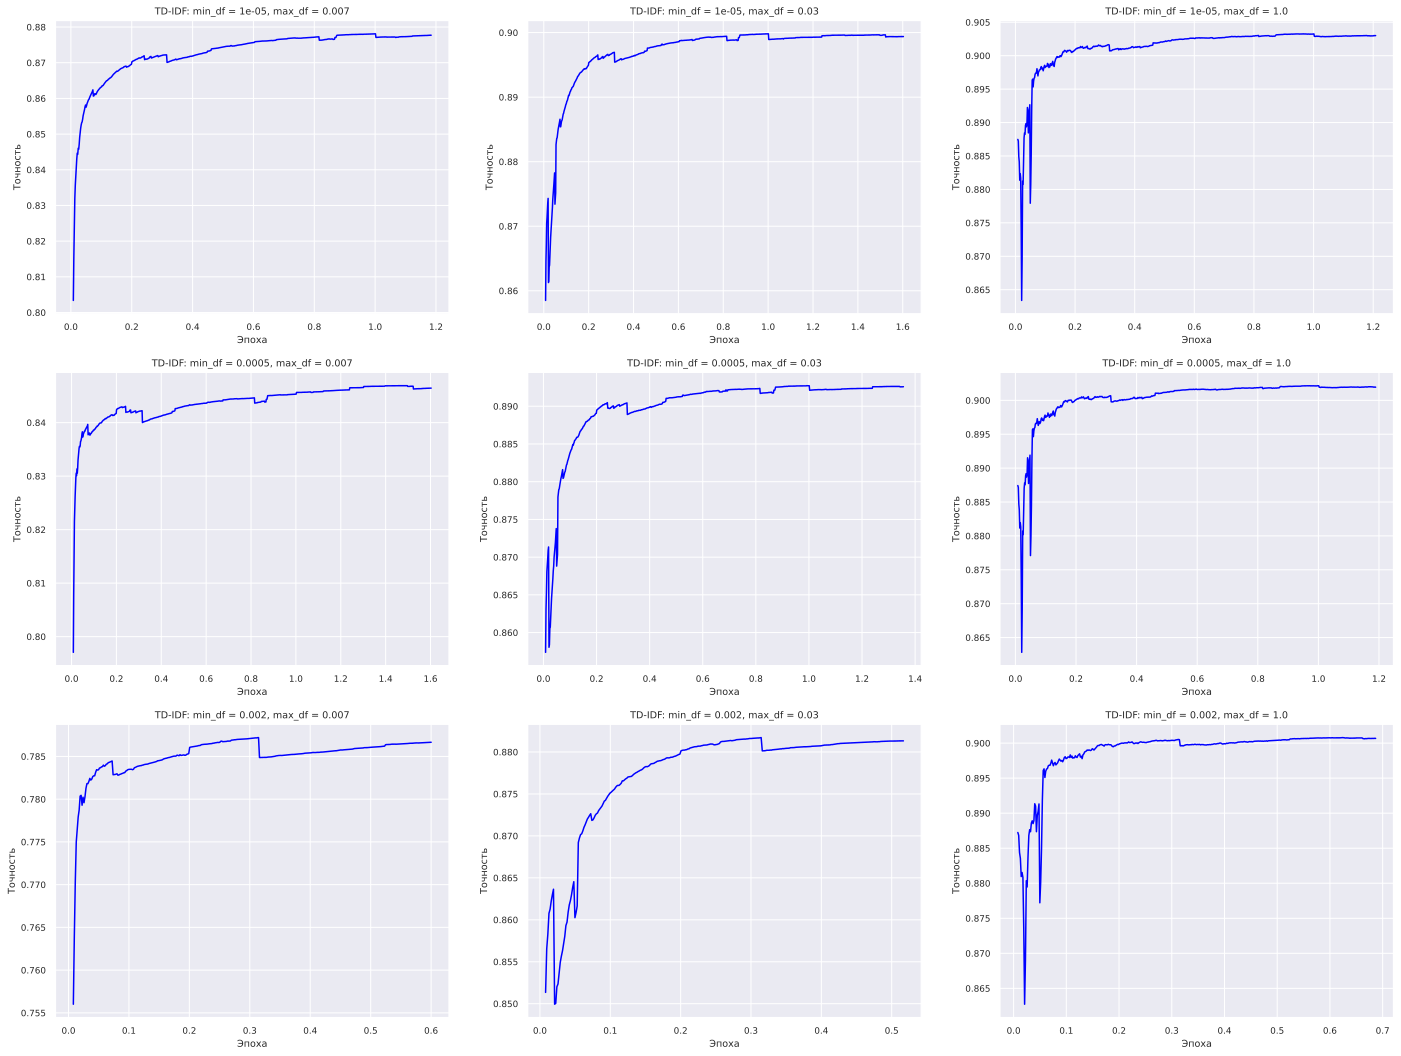

In [234]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(24, 18))

for i in range(3):
    for j in range(3):
        ax[i][j].plot(tfidf_history_dfs[i][j]['epoch_num'][5:], tfidf_history_dfs[i][j]['acc'][5:], color='blue')
        ax[i][j].ticklabel_format(style='plain', useMathText=False, useOffset=False)
        ax[i][j].set(title=f'TD-IDF: min_df = {min_dfs[i]}, max_df = {max_dfs[j]}',
                     xlabel='Эпоха',
                     ylabel='Точность')

fig.savefig('tfidf_history_dfs_acc.svg')
fig.show()

In [235]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(24, 18))

for i in range(3):
    for j in range(3):
        ax[i][j].plot(bow_history_dfs[i][j]['epoch_num'][5:], bow_history_dfs[i][j]['acc'][5:], color='blue')
        ax[i][j].ticklabel_format(style='plain', useMathText=False, useOffset=False)
        ax[i][j].set(title=f'BagOfWords: min_df = {min_dfs[i]}, max_df = {max_dfs[j]}',
                     xlabel='Эпоха',
                     ylabel='Точность')

fig.savefig('bow_history_dfs_acc.svg')
fig.show()

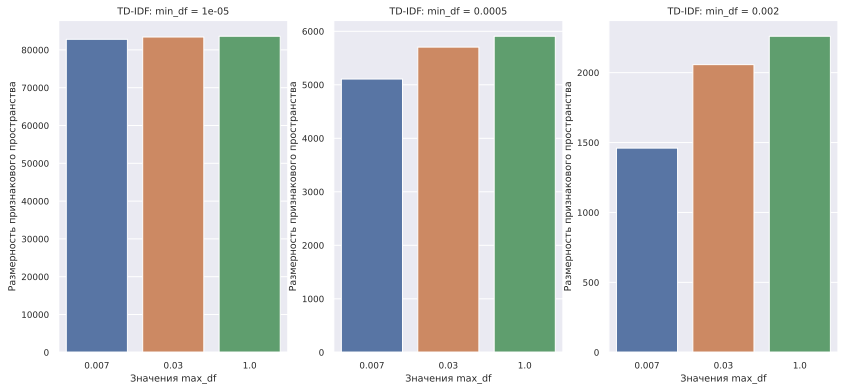

In [257]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 6))

for i in range(3):
    y = np.array([])
    for j in range(3):
        y = np.append(y, tfidf_history_dfs[i][j]['f_dimensions'])

    sns.barplot(x=max_dfs, y=y, ax=ax[i])

    ax[i].set(title=f'TD-IDF: min_df = {min_dfs[i]}',
              xlabel='Значения max_df',
              ylabel='Размерность признакового пространства')

fig.savefig('tfidf_history_dfs_fdims.svg')
fig.show()

In [258]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 6))

for i in range(3):
    y = np.array([])
    for j in range(3):
        y = np.append(y, tfidf_history_dfs[i][j]['fit_time'])

    sns.barplot(x=max_dfs, y=y, ax=ax[i])

    ax[i].set(title=f'TD-IDF: min_df = {min_dfs[i]}',
              xlabel='Значения max_df',
              ylabel='Время обучения')

fig.savefig('tfidf_history_dfs_ftime.svg')
fig.show()

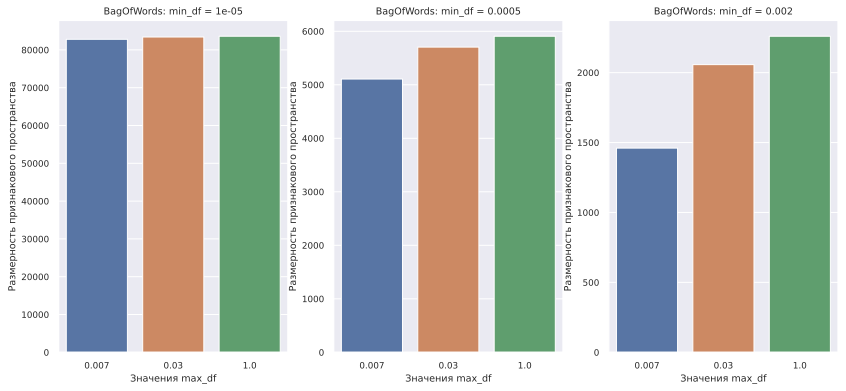

In [259]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 6))

for i in range(3):
    y = np.array([])
    for j in range(3):
        y = np.append(y, bow_history_dfs[i][j]['f_dimensions'])

    sns.barplot(x=max_dfs, y=y, ax=ax[i])

    ax[i].set(title=f'BagOfWords: min_df = {min_dfs[i]}',
              xlabel='Значения max_df',
              ylabel='Размерность признакового пространства')

fig.savefig('bow_history_dfs_fdims.svg')
fig.show()

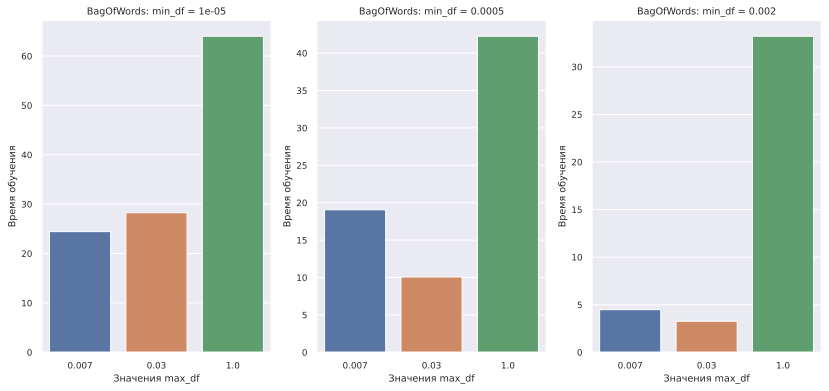

In [260]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 6))

for i in range(3):
    y = np.array([])
    for j in range(3):
        y = np.append(y, bow_history_dfs[i][j]['fit_time'])

    sns.barplot(x=max_dfs, y=y, ax=ax[i])

    ax[i].set(title=f'BagOfWords: min_df = {min_dfs[i]}',
              xlabel='Значения max_df',
              ylabel='Время обучения')

fig.savefig('bow_history_dfs_ftime.svg')
fig.show()

### Анализ полученных результатов

In [254]:
acc_max_tfidf = 0
acc_max_bow = 0

tfidf_acc_i = 0
tfidf_acc_j = 0

bow_acc_i = 0
bow_acc_j = 0

for i in range(3):
    for j in range(3):
        if tfidf_history_dfs[i][j]['acc'][-1] > acc_max_tfidf:
            acc_max_tfidf = tfidf_history_dfs[i][j]['acc'][-1]
            tfidf_acc_i = i
            tfidf_acc_j = j
        if bow_history_dfs[i][j]['acc'][-1] > acc_max_bow:
            acc_max_bow = bow_history_dfs[i][j]['acc'][-1]
            bow_acc_i = i
            bow_acc_j = j
print(f'Максимальная точность {acc_max_tfidf} у TF-IDF получается при max_df = {max_dfs[tfidf_acc_j]} и min_df = {min_dfs[tfidf_acc_i]}')
print(f'Максимальная точность {acc_max_bow} у BagOfWords получается при max_df = {max_dfs[bow_acc_j]} и min_df = {min_dfs[bow_acc_i]}')

Максимальная точность 0.9030024252527088 у TF-IDF получается при max_df = 1.0 и min_df = 1e-05
Максимальная точность 0.9033658998188894 у BagOfWords получается при max_df = 1.0 и min_df = 1e-05


При **max_df** = 1.0 и **min_df** = 1e-05 мы хоть и получаем максимальную точность, но размерность признакового пространства слишком большая. Если же взять max_df = 1.0 и min_df = 0.0005, то мы получим оптимальное значение пространства признаков, точности и времени обучения, что видно по графикам как для ***BagOfWords***, так и для ***TF-IDF***

In [267]:
print(f'Итоговая точность (TF-IDF): {tfidf_history_dfs[1][2]["acc"][-1]}')
print(f'Итоговая точность (BagOfWords): {bow_history_dfs[1][2]["acc"][-1]}')

print(f'Итоговая размерность признаков (TF-IDF): {tfidf_history_dfs[1][2]["f_dimensions"]}')
print(f'Итоговая размерность признаков (BagOfWords): {bow_history_dfs[1][2]["f_dimensions"]}')

print(f'Итоговое время работы (TF-IDF): {tfidf_history_dfs[1][2]["fit_time"]}')
print(f'Итоговая время работы (BagOfWords): {bow_history_dfs[1][2]["fit_time"]}')

Итоговая точность (TF-IDF): 0.901943335568493
Итоговая точность (BagOfWords): 0.9025825494607416
Итоговая размерность признаков (TF-IDF): 5907
Итоговая размерность признаков (BagOfWords): 5907
Итоговое время работы (TF-IDF): 69.28749632835388
Итоговая время работы (BagOfWords): 42.25680947303772


## Эксперимент 9

В данном эксперименте необходимо выбрать лучший алгоритм для тестовой выборки и проанализировать его ошибки. Отдельно требуется описать общие черты объектов, на которых допущены ошибки

Лучшая конфигурация модели выглядит следующим образом:

1. SGDClassifier ввиду, в первую очередь, своей скорости работы
2. l2_coef = 1.0
3. step_alpha = 1.0
4. step_beta = 1.0
5. batch_size = 256
6. Приближение весов с помощью скалярного произведения
7. Кодирование BagOfWords: min_df = 0.0005, max_df = 1.0

### Тестирование

In [268]:
vectorizer = CountVectorizer(min_df=0.0005, max_df=1.0, lowercase=False, stop_words='english')
vectorizer = vectorizer.fit(data_test.to_numpy().ravel())
new_data_train = vectorizer.transform(data_train.to_numpy().ravel())
new_data_test = vectorizer.transform(data_test.to_numpy().ravel())

new_data_test = new_data_test[(target_test == 0) | (target_test == 1)]
new_data_train = new_data_train[(target_train == 0) | (target_train == 1)]

new_target_test = target_test[(target_test == 0) | (target_test == 1)]
new_target_test[new_target_test == 0] = -1

new_target_train = target_train[(target_train == 0) | (target_train == 1)]
new_target_train[new_target_train == 0] = -1

clf = SGDClassifier(loss_function='binary_logistic', batch_size=256, step_alpha=1.0, step_beta=1.0, l2_coef=1.0)

start_time = time()
clf.fit(new_data_train, new_target_train)
fit_time = time() - start_time

print(f'Время обучения = {fit_time}, точность на тесте = {accuracy_score(new_target_test, clf.predict(new_data_test))}')

Время обучения = 0.25203704833984375, точность на тесте = 0.8818343805683203


### Анализ ошибок

In [315]:

target_predict = clf.predict(new_data_test).astype('int64')
target_test = new_target_test.astype('int64')

conf_matrix = confusion_matrix(target_predict, target_test)
conf_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Не токсичный', 'Токсичный']).plot()

plt.title("Матрица ошибок (тестовая выборка)")
plt.ylabel("Предсказанные метки")
plt.xlabel("Истинные метки")
plt.yticks(rotation=0)

plt.rcParams.update({'font.size': 10})

plt.savefig("cfm.svg")
plt.show()

### Ошибки, когда комментарии не являются на самом деле токсичными

In [327]:
test_df = pd.read_csv('test/test.csv', index_col=0)
test_labels = pd.read_csv('test_labels/test_labels.csv', index_col=0)
test_labels = test_labels.toxic.to_numpy()

In [333]:
test_df_known = test_df[(test_labels == 0) | (test_labels == 1)]
known_labels = test_labels[(test_labels == 0) | (test_labels == 1)]
known_labels[known_labels == 0] = -1

In [362]:
print(test_df_known.comment_text[(known_labels == -1) & (target_predict == 1)][454])

слыш, иди на хуй


Этот комментарий является токсичным, выброс в данных

In [404]:
print(test_df_known.comment_text[(known_labels == -1) & (target_predict == 1)][29])

" 
 == Anarcho-fascism == 
 Great TNX for bot activity! ""Слава Роботам!!!"" (c)   "


Вероятно, fascism, либо bot посчитались за токсичные слова, хотя контекст не подразумевает токсичности

In [419]:
print(test_df_known.comment_text[(known_labels == -1) & (target_predict == 1)][150])

== Stefan == 

 Stefan is a HORNY PEDOBEAR O:


Комментарий является, скорее всего, шуткой, однако слова Horny и Pedobear воспринимаются моделью как токсичные

In [431]:
print(test_df_known.comment_text[(known_labels == -1) & (target_predict == 1)][310])

Phillip Trueman is a p*ssy destroyer.


Слово destroyer в данном контексте может быть принято за токсичность

#### Вывод
Модель ошибается либо на выбросах, либо на предложениях, в которых "токсичные" слова употребляются в нетоксичном контексте. Контекст наша модель понимать не в состоянии. Также стоит заметить, что данные зашумлены разными языками, лишними символами, что также влияет на работу модели.

### Ошибки, когда комментарии на самом деле являются токсичными

In [432]:
print(test_df_known.comment_text[(known_labels == 1) & (target_predict == -1)][0])

== Arabs are committing genocide in Iraq, but no protests in Europe. == 

 May Europe also burn in hell.


В данном комментарии сочетание слов Europe, burn, hell несёт в себе токсичность. Однако эти слова могут использоваться и далеко не в токсичном смысле, из-за чего модель не может определить данный комментарий токсичным.

In [433]:
print(test_df_known.comment_text[(known_labels == 1) & (target_predict == -1)][1])

DJ Robinson is gay as hell! he sucks his dick so much!!!!!


Токсичность этого предложения определяется словами gay, hell, sucks, dick, а также контекстом употребления с конкретным человеком. Эти слова не являются определяющими для токсичности, так как, например, после перевода всех строк в нижний регистр имя Dick перейдёт в dick, а оставшиеся слова далеко не всегда употребляются в токсичном смысле

In [434]:
print(test_df_known.comment_text[(known_labels == 1) & (target_predict == -1)][2])

:Fuck off, you anti-semitic cunt.  |


Данное предложение показывает, что, вероятно, присутствует переобучение на исходных данных, так как слово *fuck* - токсичное

In [437]:
print(test_df_known.comment_text[(known_labels == 1) & (target_predict == -1)][5])

:Eek, but shes cute in an earthy kind of way. Cant sing for shit though. Thanks for giving me an unhappy memory.


Данное предложение отлично показывает пример того, что слово shit может употребляться не в токсичном смысле. Смысл из комментариев наша модель "вытаскивать" не может.

#### Вывод

Модель в основном ошибается из-за того, что не понимает контекст и смысл предложения, так как многие слова, использующиеся в токсичном смысле, могут использоваться как в саркастических, так и в иных, не являющихся токсичными, смыслах. То есть ошибка модели происходит из-за непонимания смысла предложения

### Итог эксперимента

Ошибки модели логистической регрессии в первую очередь связаны с непониманием смысла предложений. Она рассматривает каждое слово в отдельности, присваивая ему "степень" токсичности как вес, не учитывая часть речи, позицию в предложении, возможные скрытые буквы, а также смысл, которое несёт данное слово. Смысл же можно понять только из контекста

# Код для загрузки объектов сессии на диск

In [236]:
import pickle

with open('/content/drive/MyDrive/Colab Dumps/history_GD.dat', "wb") as file:
    pickle.dump(history, file)


with open('/content/drive/MyDrive/Colab Dumps/history_GD_w0.dat', "wb") as file:
    pickle.dump(history_w_0, file)


with open('/content/drive/MyDrive/Colab Dumps/history_SGD.dat', "wb") as file:
    pickle.dump(history_sgd, file)


with open('/content/drive/MyDrive/Colab Dumps/history_SGD_w0.dat', "wb") as file:
    pickle.dump(history_sgd_w_0, file)


with open('/content/drive/MyDrive/Colab Dumps/history_SGD_w1_batches.dat', "wb") as file:
    pickle.dump(history_sgd_w_1, file)


with open('/content/drive/MyDrive/Colab Dumps/tfidf_history_dfs.dat', "wb") as file:
    pickle.dump(tfidf_history_dfs, file)


with open('/content/drive/MyDrive/Colab Dumps/bow_history_dfs.dat', "wb") as file:
    pickle.dump(bow_history_dfs, file)


# with open('/content/drive/MyDrive/Colab Dumps/history_GD.dat', "rb") as file:
#     history = pickle.load(file)

# with open('/content/drive/MyDrive/Colab Dumps/history_SGD.dat', "rb") as file:
#     history_sgd = pickle.load(file)